In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')  

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
%matplotlib inline
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf
matplotlib.style.use('fivethirtyeight')
matplotlib.style.use('seaborn-talk')

## <font color='steelblue'>Report of Activities in support of the IBA-IOBS Project: "Proton Therapy vs. Traditional Radiation therapy: Total Cost of care, Effects on Survival, liklihood of complications and Qualtiy of Life."</font>

Below we will present

* a timeline of the of the steps taken to acquire the SEER-Medicare data
    * All necessary steps have been taken; IOBS has been informed that we can expect delivery within 2-4 weeks.
* a brief description of a commecial claims data source, including the results of pricing inquiries.
    * Truven Health, deidentified commercial (and Medicare) claims data
* a descrition of the SEER-Medicare data files and their format.

as well as preliminary work and results on Patient Matching using KDTrees; a more direct approach to patient matching than the traditional Propensity Score Matching methods. Needed as a foundational step to make meaningful comparisons between Proton Therapy patients and their traditional radiation thearpy counterparts.

* Left-sided breast cancer patients
* prostate cancer patients

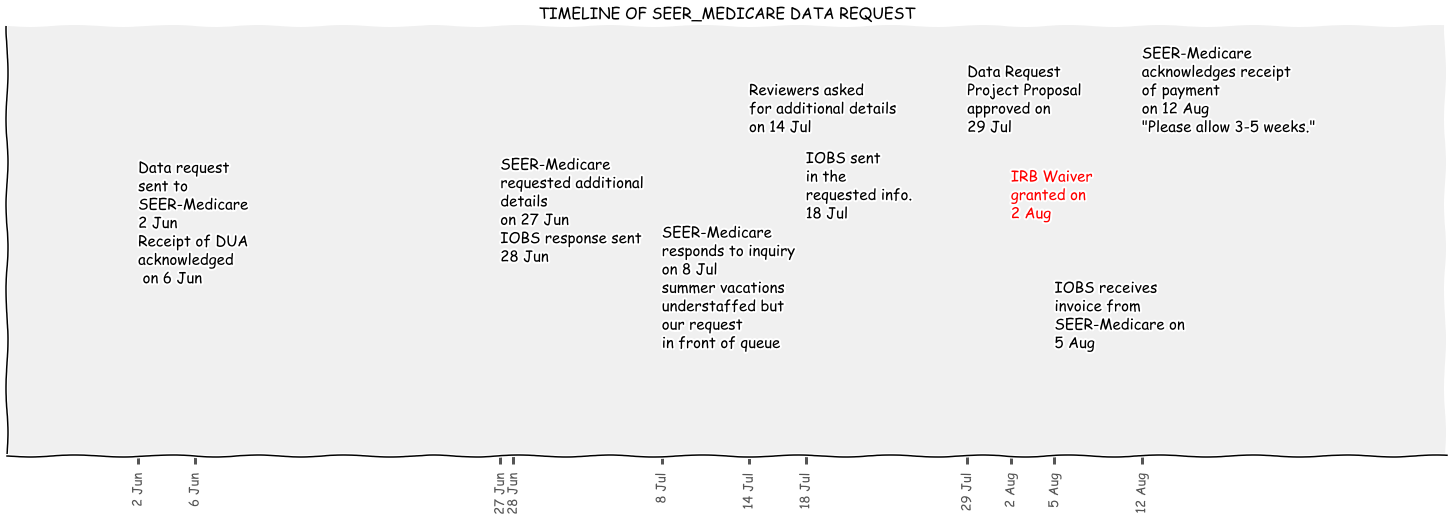

In [111]:
import matplotlib.pyplot as plt
import numpy as np

with plt.xkcd():
    # Based on "Stove Ownership" from XKCD by Randall Monroe
    # http://xkcd.com/418/
    fig = plt.figure(figsize=(10,6))
    ax = fig.add_axes((0.0, 0.0, 2, 1))
    #ax.bar([-0.325, 1.0 - 0.325], [0, 100], 0.25)
    ax.spines['right'].set_color('none')
    ax.spines['top'].set_color('none')
    ax.xaxis.set_ticks_position('bottom')
    ax.set_xticks([0, .13, .83, .86, 1.2,
                   1.4, 1.53, 1.9, 2.0,
                  2.1, 2.3])
    ax.set_xlim([-0.3, 3])
    ax.set_ylim([0, 2])
    ax.set_xticklabels(['2 Jun', '6 Jun', '27 Jun', '28 Jun','8 Jul', 
                       '14 Jul', '18 Jul', '29 Jul', '2 Aug',
                       '5 Aug', '12 Aug'],
                      rotation=90)
    plt.yticks([])

    ax.text(0,.8, 'Data request\nsent to\nSEER-Medicare\n2 Jun\nReceipt of DUA\n' +
    'acknowledged\n on 6 Jun', 
           style='italic',fontsize=15)
    
    
    ax.text(.83,.9, 'SEER-Medicare\nrequested additional\n' +
    'details\non 27 Jun\nIOBS response sent\n28 Jun', 
           style='italic',fontsize=15)
    
    ax.text(1.2, .5, 'SEER-Medicare\nresponds to inquiry\non 8 Jul\nsummer vacations\nunderstaffed but\n' + 
           'our request\nin front of queue',
           style='italic',fontsize=15)
    
    ax.text(1.4, 1.5,'Reviewers asked\nfor additional details\non 14 Jul',
           style='italic',fontsize=15)
    
    
    ax.text(1.53, 1.1, 'IOBS sent\nin the\nrequested info.\n18 Jul',
           style='italic',fontsize=15)
    
    ax.text(1.9,1.5,'Data Request\nProject Proposal\napproved on\n' + 
           '29 Jul',style='italic',fontsize=15)
    
    
    ax.text(2.0, 1.1, 'IRB Waiver\ngranted on\n2 Aug',
           style='italic',fontsize=15,color='red')
    
    
    ax.text(2.1, .5, 'IOBS receives\ninvoice from\n' + 
           'SEER-Medicare on\n5 Aug',
           style='italic',fontsize=15)
    
    
    ax.text(2.3, 1.5, 'SEER-Medicare\nacknowledges receipt\nof payment\n' +
           'on 12 Aug\n"Please allow 3-5 weeks."',
           style='italic',fontsize=15)
    
    
    plt.annotate(
        'THE DAY I REALIZED\nI COULD COOK BACON\nWHENEVER I WANTED',
        xy=(70, 1), arrowprops=dict(arrowstyle='->'), xytext=(15, -10))
    
    plt.title("TIMELINE OF SEER_MEDICARE DATA REQUEST")

#    fig.text(
    #    0.5, 0.05,
    #    '"The Data So Far" from xkcd by Randall Monroe',
     #   ha='center')

#fig.set_size_inches(5, 6)        
#fig.savefig('timeline.png',dpi=100)
plt.show()

### <font color='steelblue'>Will have SEER-Medicare Data on site early to mid September</font>

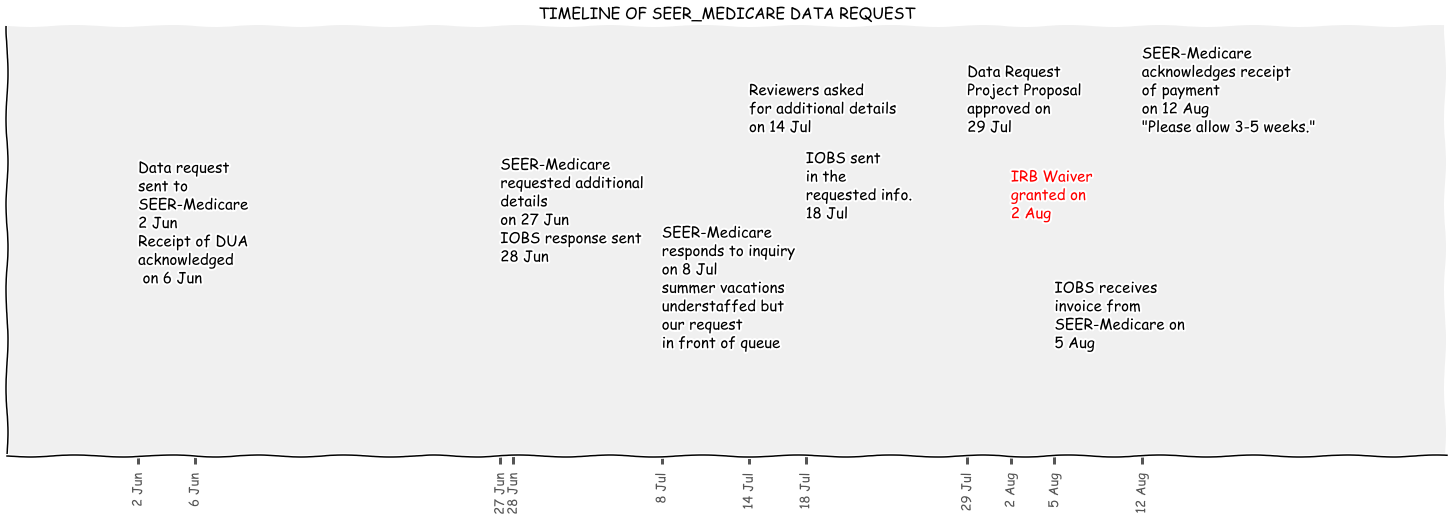

In [112]:
from IPython.display import Image
Image('timeline.png',embed=True)

In [113]:
from IPython.display import IFrame

#### Another data source: Truven Health MarketScan Databases

In [114]:
IFrame("http://truvenhealth.com/markets/life-sciences/products/data-tools/marketscan-databases",
      width=800,height=400)

## <font color='steelblue'>Description of the SEER-Medicare Data Files format</font>

* Patient Entitlement and Diagnosis Summary File (PEDSF)
* Medicare Provider Analysis and Review (MEDPAR)
* Outpatient Claims
* Home Health Agency (HHA)
* Hospice
* Durable Medical Equipment (DME)
* Medicare Part D Data

#### PEDSF File

In [117]:
IFrame("http://healthcaredelivery.cancer.gov/seermedicare/aboutdata/pedsf_attachment_a.pdf",
      width=800,height=400)

The PEDSF File is almost identical to the SEER file that is easily available at no cost. IOBS has developed the code to read in this file, and transform values according to the codebook documentation.

In [ ]:
# %load seerhelp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import Series, DataFrame
import pytz
from pytz import common_timezones, all_timezones
import matplotlib
matplotlib.style.use('ggplot')
from datetime import datetime
import scipy as sp
import statsmodels.api as sm
import statsmodels.formula.api as smf


filelistyr1973_2013 = ['SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\COLRECT.TXT',
           'SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\BREAST.TXT',
           'SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\DIGOTHR.TXT',
           'SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\FEMGEN.TXT',
           'SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\LYMYLEUK.TXT',
           'SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\MALEGEN.TXT',
           'SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\OTHER.TXT',
           'SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\RESPIR.TXT',
           'SEER_1973_2013_TEXTDATA\\incidence\\yr1973_2013.seer9\\URINARY.TXT']




filelistyr1992_2013 = ['SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\COLRECT.TXT',
             'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\BREAST.TXT',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\DIGOTHR.TXT',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\FEMGEN.TXT',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\LYMYLEUK.TXT',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\MALEGEN.TXT',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\OTHER.TXT',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\RESPIR.TXT',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr1992_2013.sj_la_rg_ak\\URINARY.TXT']



filelistyr2000_2013 = ['SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\COLRECT.TXT',
    'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\BREAST.TXT',
    'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\DIGOTHR.TXT',
    'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\FEMGEN.TXT',
     'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\LYMLEUK.TXT',
    'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\MALEGEN.TXT',
    'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\OTHER.TXT',
    'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\RESPIR.TXT',
    'SEER_1973_2013_TEXTDATA\\incidence\\yr2000_2013.ca_ky_lo_nj_ga\\URINARY.TXT']



filelistyr2005 = ['SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\COLRECT.txt',
                'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\BREAST.txt',
             'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\DIGOTHR.txt',
               'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\FEMGEN.txt',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\LYMLEUK.txt',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\MALEGEN.txt',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\OTHER.txt',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\RESPIR.txt',
            'SEER_1973_2013_TEXTDATA\\incidence\\yr2005.lo_2nd_half\\URINARY.txt']



colorectfiles = [filelistyr1973_2013[0], filelistyr1992_2013[0],
                filelistyr2000_2013[0], filelistyr2005[0]]

breastfiles = [filelistyr1973_2013[1], filelistyr1992_2013[1],
                filelistyr2000_2013[1], filelistyr2005[1]]

digothrfiles = [filelistyr1973_2013[2], filelistyr1992_2013[2],
                filelistyr2000_2013[2], filelistyr2005[2]]

femgenfiles = [filelistyr1973_2013[3], filelistyr1992_2013[3],
                filelistyr2000_2013[3], filelistyr2005[3]]

lymleukfiles = [filelistyr1973_2013[4], filelistyr1992_2013[4],
                filelistyr2000_2013[4], filelistyr2005[4]]

malegenfiles = [filelistyr1973_2013[5], filelistyr1992_2013[5],
                filelistyr2000_2013[5], filelistyr2005[5]]

otherfiles = [filelistyr1973_2013[6], filelistyr1992_2013[6],
                filelistyr2000_2013[6], filelistyr2005[6]]

respirfiles = [filelistyr1973_2013[7], filelistyr1992_2013[7],
                filelistyr2000_2013[7], filelistyr2005[7]]

urinaryfiles = [filelistyr1973_2013[8], filelistyr1992_2013[8],
                filelistyr2000_2013[8], filelistyr2005[8]]




def get_colorectfiles():
    """Get a list of the colorecfiles."""
    return colorectfiles


def get_breastfiles():
    """Get a list of the breastfiles."""
    return breastfiles


def get_digothrfiles():
    """Get a list of the digothrfiles."""
    return digothrfiles



def get_femgenfiles():
    """Get a list of the femgenfiles."""
    return femgenfiles

def get_lymleukfiles():
    """Get a list of the lymleukfiles."""
    return lymleukfiles

def get_malegenfiles():
    """Get a list of the malegenfiles."""
    return malegenfiles

def get_otherfiles():
    """Get a list of the otherfiles."""
    return otherfiles


def get_respirfiles():
    """Get a list of the respirfiles."""
    return respirfiles



def get_urinaryfiles():
    """Get a list of the urinaryfiles."""
    return urinaryfiles


##########################################################################

def make_icd9dx_dataframe():
    """Make a dataframe that includes the icd9dx descriptions."""
    
    dficd9dx = pd.read_excel('CMS32_DESC_LONG_SHORT_DX.xlsx',
                        convert_float=False,
                        converters = {'PROCEDURE CODE': str})
    dficd9dx = dficd9dx.rename(columns={'DIAGNOSIS CODE': 'code',
                                    'LONG DESCRIPTION': 'long_description',
                        'SHORT DESCRIPTION': 'short_description'})

    return dficd9dx

##########################################################################

def make_icd9sg_dataframe():
    """Make a dataframe that includes the icd9sg descriptins."""
    
    dficd9sg = pd.read_excel('CMS32_DESC_LONG_SHORT_SG.xlsx',
                        convert_float=False,
                        converters = {'PROCEDURE CODE': str})
    dficd9sg = dficd9sg.rename(columns={'PROCEDURE CODE': 'code',
                        'LONG DESCRIPTION': 'long_description',
                        'SHORT DESCRIPTION': 'short_description'})

    return dficd9sg


##################################################################################


def icd9dx_description_trans(df,dficd9dx,columnname):
    """takes the dataframe df and the columnname as a string and adds a 
    column containing the long description to df using the 
    description string in dficd9dx"""
    
    dfhuh = pd.merge(df[[columnname]].astype('str'), dficd9dx,
                 left_on=columnname, right_on='code',how='left')
    df[columnname + '_description'] = dfhuh['long_description']
    del dfhuh



###################################################################################





specsdict = {'PUBCSNUM': (0,8),
             'REG': (8,18),'MAR_STAT': (18,19),'RACEIV': (19,21),
             'NHIADE': (22,23),'SEX': (23,24),'AGE_DX': (24,27),
             'YR_BRTH': (27,31),'SEQ_NUM': (34,36),'MDXRECMP': (36,38),
              'YEAR_DX': (38,42), 'PRIMSITE': (42,46), 'LATERAL': (46,47), 
            'HISTO2V': (47,51), 'BEHO2V': (51,52), 'HISTO3V': (52,56),
            'BEHO3V': (56,57), 'GRADE': (57,58), 'DX_CONF': (58,59),
            'REPT_SRC': (59,60), 'EOD10_SZ': (60,63), 'EOD10_EX': (63,65),
            'EOD10_PE': (65,67), 'EOD10_ND': (67,68), 'EOD10_PN': (68,70),
            'EOD10_NE': (70,72), 'EOD13': (72,85), 'EOD2': (85,87),
            'EOD4': (87,91), 'EOD_CODE': (91,92), 'TUMOR_1V': (92,93),
             'TUMOR_2V': (93,94), 'TUMOR_3V': (94,95), 'CSTUMSIZ': (95,98),
            'CSEXTEN': (98,101), 'CSLYMPHN': (101,104), 'CSMETSDX': (104,106),
             'CS1SITE': (106,109), 'CS2SITE': (109,112), 'CS3SITE': (112,115),
             'CS4SITE': (115,118), 'CS5SITE': (118,121), 'CS6SITE': (121,124),
             'CS25SITE': (124,127), 'DAJCCT': (127,129), 'DAJCCN': (129,131),
             'DAJCCM': (131,133), 'DAJCCSTG': (133,135), 'DSS1977S': (135,136),
             'DSS2000S': (136,137), 'DAJCCFL': (137,138), 'CSVFIRST': (140,146),
             'CSVLATES': (146,152), 'CSVCURRENT': (152,158), 'SURGPRIF': (158,160),
             'SURGSCOF': (160,161), 'SURGSITF': (161,162), 'NUMNODES': (162,163),
             'NO_SURG': (165,166), 'RADIATN': (166,167), 'RAD_BRN': (167,168),
             'RAD_SURG': (168,169), 'SS_SURG': (169,171), 'SURGSCOP': (173,174),
             'SURGSITE': (174,175), 'REC_NO': (175,177), 'TYPE_FU': (190,191),
             'AGE_1REC': (191,193), 'SITERWHO': (198,203), 'ICDOTO9V': (203,207),
             'ICDOT10V': (207,211), 'ICCC3WHO': (217,220), 'ICCC3XWHO': (220,223),
             'BEHTREND': (223,224), 'HISTREC': (225,227), 'HISTRECB': (227,229),
             'cs0204schema': (229,232), 'RAC_RECA': (232,233), 'RAC_RECY': (233,234),
             'ORIGRECB': (234,235), 'HST_STGA': (235,236), 'AJCC_STG': (236,238),
             'AJ_3SEER': (238,240), 'SSS77VZ': (240,241), 'SSSM2KPZ': (241,242),
             'FIRSTPRM': (244,245), 'ST_CNTY': (245,250), 'CODPUB': (254,259),
             'CODPUBKM': (259,264), 'STAT_REC': (264,265), 'IHSLINK': (265,266),
             'SUMM2K': (266,267), 'AYASITERWHO': (267,269), 'LYMSUBRWHO': (269,271),
             'VSRTSADX': (271,272), 'ODTHCLASS': (272,273), 'CSTSEVAL': (273,274),
             'CSRGEVAL': (275,275), 'CSMTEVAL': (275,276), 'intprim': (276,277),
             'erstatus': (277,278), 'prstatus': (278,279), 'csschema': (279,282),
             'CS8SITE': (281,284), 'CS10SITE': (284,287), 'CS11SITE': (287,290),
             'CS13SITE': (290,293), 'CS15SITE': (294,296), 'CS16SITE': (296,299),
             'VASINV': (299,300), 'srv_time_mon': (300,304), 'srv_time_mon_flag': (304,305),
             'INSREC_PUB': (310,311), 'DAJCC7T': (311,314), 'DAJCC7N': (314,317),
             'DAJCC7M': (317,320), 'DAJCC7STG': (320,323), 'ADJTM_6VALUE': (323,325), 
             'ADJNM_6VALUE': (325,327), 'ADJM_6VALUE': (327,329), 'ADJAJCCSTG':(329,331),
             'CS7SITE': (331,334), 'CS9SITE': (334,337), 'CS12SITE': (337,340),
             'her2': (340,341), 'brst_sub': (341,342), 'ANNARBOR': (347,348), 
             'CSMETSDXB_PUB': (348,349), 'CSMETSDXBR_PUB': (349,350),
             'CSMETSDXLIV_PUB': (350,351), 'CSMETSDXLUNG_PUB': (351,352),
            'T_VALUE': (352,353), 'N_VALUE': (354,355), 'M_VALUE': (356,357)}


#colspecs = list(specsdict.values())
#names = list(specsdict.keys())




names = sorted(specsdict,key=specsdict.__getitem__)

colspecs = [specsdict[n] for n in names]


replacedict = dict()

###################################################################################

REGdict = {1501: 'San Fransisco-Oakland SMSA', 
           1502: 'Connecticut',
           1520: 'Metropolitan Detroit',
           1521: 'Hawaii',
           1522: 'Iowa',
            1523: 'New Mexico',
            1525: 'Seattle (Puget Sound)',
            1526: 'Utah',
            1527: 'Metropolitan Atlanta',
           1529: 'Alaska',
           1531: 'San Jose-Monterey',
           1535: 'Los Angeles',
           1537: 'Rural Georgia',
           1541: 'Greater California (excluding SF, Los Angeles & SJ)',
           1542: 'Kentucky',
           1543: 'Louisiana',
           1544: 'New Jersey',
           1547: 'Greater Georgia (excluding AT and RG)'}

#################################################################################################

MAR_STATdict = {1: 'Single (never married)',
                2: 'Married (including common law)',
                3: 'Separated',
                4: 'Divorced',
                5: 'Widowed',
                6: 'Unmarried or domestic partner (same sex or opposite sex or unregistered)',
                9: 'Unknown'}

##################################################################################################

RACEIVdict = {1: 'White',
              2: 'Black',
              3: 'American Indian, Aleutian, Alaska Native or Eskimo (includes all indigenous populations of the Western hemisphere)',
              4: 'Chinese',
              5: 'Japanese',
              6: 'Filipino',
              7: 'Hawaiian',
              8: 'Korean',
              10: 'Vietnamese',
              11: 'Laotian',
              12: 'Hmong',
              13: 'Kampuchean (including Khmer and Cambodian)',
              14: 'Thai',
              15: 'Asian Indian or Pakistani, NOS',
              16: 'Asian Indian',
              17: 'Pakistani',
              20: 'Micronesian, NOS',
              21: 'Chamorran',
              22: 'Guamanian, NOS',
              25: 'Polynesian, NOS',
              26: 'Tahitian',
              27: 'Samoan',
              28: 'Tongan',
              30: 'Melanesian, NOS',
              31: 'Fiji Islander',
              32: 'New Guinean',
              96: 'Other Asian, including Asian, NOS and Oriental NOS',
              97: 'Pacific Islander, NOS',
              98: 'Other',
              99: 'Unknown'}

#######################################################################################

NHIADEdict = {0: 'Non-Spanish-Hispanic-Latino',
              1: 'Mexican',
              2: 'Puerto Rican',
              3: 'Cuban',
              4: 'South or Central American excluding Brazil',
              5: 'Other specified Spanish/Hispanic Origin including Europe',
              6: 'Spanish/Hispanic/Latino, NOS',
              7: 'NHIA Surname Match Only',
              8: 'Dominican Republic'}

################################################################################

SEXdict = {1: 'Male',
           2: 'Female'}

#####################################################################################

AGE_DXdict = {999: 'Unknown age'}

YR_BRTHdict = {0: 'Unknown year of birth'}


###############################################################

MDXRECMPdict = {1:'Jan',
                2: 'Feb',
                3: 'Mar',
                4: 'Apr',
                5: 'May',
                6: 'Jun',
                7: 'Jul',
                8: 'Aug',
                9: 'Sep',
                10: 'Oct',
                11: 'Nov',
                12: 'Dec'}

########################################################################################

PRIMSITEdict = {  'C000':   'External upper lip',
                  'C001':    'External lower lip',
                  'C002':    'External lip, NOS',
                  'C003':   'Mucosa of upper lip',
                  'C004':   'Mucosa of lower lip',
                  'C005':    'Mucosa of lip, NOS',
                  'C006':    'Commissure of lip',
                  'C008':    'Overlapping lesion of lip',
                  'C009':    'Lip, NOS',
                  'C019':    'Base of tongue, NOS',
                  'C020':    'Dorsal surface of tongue, NOS',
                  'C021':     'Border of tongue',
                  'C022':    'Ventral surface of tongue, NOS',
                  'C023':    'Anterior 2/3 of tongue, NOS',
                  'C024':    'Lingual tonsil',
                  'C028':    'Overlapping lesion of tongue',
                  'C029':    'Tongue, NOS',
                  'C030':    'Upper Gum',
                  'C031':    'Lower gum',
                  'C039':    'Gum, NOS',
                  'C040':    'Anterior floor of mouth',
                  'C041':    'Lateral floor of mouth',
                  'C048':    'Overlapping lesion of floor of mouth',
                  'C049':    'Floor of mouth, NOS',
                   'C050':    'Hard palate',
                  'C051':    'Soft palate, NOS',
                  'C052':    'Uvula',
                  'C058':    'Overlapping lesion of palate',
                  'C059':    'Palate, NOS',
                  'C060':    'Cheeck mucosa',
                  'C061':    'Vestibule of mouth',
                  'C062':    'Retromolar area',
                  'C068':    'Overlapping lesion of other and unspecified parts of mouth',
                  'C069':    'Mouth, NOS',
                  'C079':    'Parotid gland',
                  'C080':    'Submandibular gland',
                  'C081':    'Sublingual gland',
                  'C088':    'Overlapping lesion of major salivary glands',
                  'C089':    'Major salivary gland, NOS',
                  'C090':    'Tonsillar fossa',
                  'C091':    'Tonsillar pillar',
                  'C098':    'Overlapping lesion of tonsil',
                  'C099':    'Tonsil, NOS',
                   'C100':    'Vallecula',
                  'C101':    'Anterior surface of epiglottis',
                  'C102':    'Lateral wall of oropharynx',
                  'C103':    'Posterior wall of oropharynx',
                  'C104':    'Branchial cleft',
                  'C108':    'Overlapping lesions of oropharynx',
                  'C109':    'Oropharynx, NOS',
                  'C110':    'Superior wall of nasopharynx',
                  'C111':    'Posterior wall of nasopharynx',
                  'C112':    'Lateral wall of nasopharynx',
                  'C113':    'Anterior wall of nasopharynx',
                  'C118':    'Overlapping lesion of nasopharynx',
                  'C119':    'Nasopharynx, NOS',
                  'C129':    'Pyriform sinus',
                  'C130':    'Postcricoid region',
                  'C131':    'Hypopharyngeal aspect of aryepiglottic fold',
                  'C132':    'Posterior wall of hypopharynx',
                  'C138':    'Overlapping lesion of hypopharynx',
                  'C139':    'Hypopharynx, NOS',
                  'C140':    'Pharynx, NOS',
                  'C142':    'Waldeyer ring',
                  'C148':    'Overlapping lesion of lip, oral cavity and pharynx',
                    'C150':    'Cervical esophagus',
                  'C151':    'Thoracic esophagus',
                  'C152':    'Abdominal esophagus',
                  'C153':    'Upper third of esophagus',
                  'C154':    'Middle third of esophagus',
                  'C155':    'Lower third of esophagus',
                  'C158':    'Overlapping lesion of esophagus',
                  'C159':    'Esophagus, NOS',
                  'C160':    'Cardia, NOS',
                  'C161':    'Fundus of stomach',
                  'C162':    'Body of stomach',
                  'C163':    'Gastric antrum',
                  'C164':    'Pylorus',
                  'C165':    'Lesser curvature of stomach, NOS',
                  'C166':    'Greater curvature of stomach, NOS',
                  'C168':    'Overlapping lesion of stomach',
                  'C169':    'Stomach, NOS',
                  'C170':    'Duodenum',
                  'C171':    'Jejunum',
                  'C172':    'Ileum',
                  'C173':    'Meckel diverticulum',
                  'C178':    'Overlapping lesion of small intestine',
                  'C179':    'Small intestine, NOS',
                  'C180':    'Cecum',
                  'C181':    'Appendix',
                  'C182':    'Ascending colon',
                  'C183':    'Hepatic flexure of colon',
                  'C184':    'Transverse colon',
                  'C185':    'Splenic flexure of colon',
                  'C186':    'Descending colon',
                  'C187':    'Sigmoid colon',
                  'C188':    'Overlapping lesion of colon',
                  'C189':    'Colon, NOS',
                   'C199':    'Rectosigmoid junction',
                   'C209':    'Rectum, NOS',
                    'C210':    'Anus, NOS',
                  'C211':    'Anal canal',
                  'C212':    'Cloacogenic zone',
                  'C218':    'Overlapping lesion of rectum, anus and anal canal',
                  'C220':    'Liver',
                  'C221':    'intrahepatic bile duct',
                     'C239':    'Gallbladder',
                      'C240':    'Extrahepatic bile duct',
                  'C241':   'Ampulla of Vater',
                  'C248':    'Overlapping lesion of billiary tract',
                  'C249':    'Billiary tract, NOS',
                   'C250':    'Head of pancreas',
                  'C251':    'Body of pancreas',
                  'C252':    'Tail of pancreas',
                  'C253':    'Pancreatic duct',
                  'C254':    'Islets of Langerhans',
                  'C257':    'Other specified parts of pancreas',
                  'C258':    'Overlapping lesion of pancreas',
                  'C259':    'Pancreas, NOS',
                  'C260':    'Intestinal tract, NOS',
                  'C268':    'Overlapping lesion of digestive system',
                  'C269':    'Gastrointestinal tract, NOS',
                   'C300':    'Nasal cavity',
                  'C301':    'Middle ear',
                     'C310':    'Maxillary sinus',
                  'C311':    'Ethmoid sinus',
                  'C312':    'Frontal sinus',
                  'C313':    'Sphenoid sinus',
                  'C318':    'Overlapping lesion of accessory sinuses',
                  'C319':    'Accessory sinus, NOS',
                    'C320':    'Glottis',
                  'C321':    'Supraglottis',
                  'C322':    'Subglottis',
                  'C323':    'Laryngeal cartilage',
                  'C328':    'Overlapping lesion of larynx',
                  'C329':    'Larynx, NOS',
                  'C339':    'Trachea',
                   'C340':    'Main bronchus',
                  'C341':    'Upper lobe, lung',
                  'C342':    'Middle lobe, lung',
                  'C343':    'Lower lobe, lung',
                  'C348':    'Overlapping lesion of lung',
                  'C349':    'Lung, NOS',
                  'C379':    'Thymus',
                  'C380':    'Heart',
                  'C381':    'Anterior mediastinum',
                  'C382':    'Posterior mediastinum',
                  'C383':    'Mediastinum, NOS',
                  'C384':    'Pleura, NOS',
                  'C388':    'Overlapping lesion of heart, mediastinum and pleura',
                   'C390':    'Upper respiratory tract, NOS',
                  'C398':    'Overlapping lesion of respiratory system and intrathoracic organs',
                  'C399':    'Ill-defined sites within respiratory system',
                     'C400':    'Long bones of upper limb, scapula and associated joints',
                  'C401':    'Short bones of upper limb and associated joints',
                  'C402':    'Long bones of lower limb and associated joints',
                  'C403':    'Short bones of lower limb and associated joints',
                  'C408':    'Overlapping lesion of bones, joints and articular cartilage of limbs',
                  'C409':    'Bone of limb, NOS',
                    'C410':    'Bones of skull and face and associated joints',
                  'C411':    'Mandible',
                  'C412':    'Vertebral column',
                  'C413':    'Rib, sternum, clavicle and associated joints',
                  'C414':    'Pelvic bones, sacrum, coccyx and associated joints',
                  'C418':    'Overlapping lesion of bones, joints and articular cartilage',
                  'C419':    'Bone, NOS',
                    'C420':    'Blood',
                  'C421':    'Bone marrow',
                  'C422':    'Spleen',
                  'C423':    'Reticuloendothelial system, NOS',
                  'C424':    'Hematopoietic system, NOS',
                   'C440':    'Skin of lip, NOS',
                  'C441':    'Eyelid',
                  'C442':    'External ear',
                  'C443':    'Skin of other and unspecified parts of face',
                  'C444':    'Skin of scalp and neck',
                  'C445':    'Skin of trunk',
                  'C446':    'Skin of upper limb and shoulder',
                  'C447':    'Skin of lower limb and hip',
                  'C448':    'Overlapping lesion of skin',
                  'C449':    'Skin, NOS',
                   'C470':    'Peripheral nerves and autonomic nervous system of head, face, and neck',
                  'C471':    'Peripheral nerves and autonomic nervous system of upper limb and shoulder',
                  'C472':    'Peripheral nerves and autonomic nervous system of lower limb and hip',
                  'C473':    'Peripheral nerves and autonomic nervous system of thorax',
                  'C474':    'Peripheral nerves and autonomic nervous system of abdomen',
                  'C475':    'Peripheral nerves and autonomic nervous system of pelvis',
                  'C476':    'Peripheral nerves and autonomic nervous system of trunk, NOS',
                  'C478':    'Overlapping lesion of peripheral nerves and autonomic nervous system',
                  'C479':    'Autonomic nervous system, NOS',
                  'C480':    'Retroperitoneum',
                  'C481':    'Specified parts of peritoneum',
                  'C482':    'Peritoneum, NOS',
                  'C488':    'Overlapping lesion of retroperitoneum and peritoneum',
                  'C490':    'Connective, Subcutaneous and other soft tissues of head, face, and neck',
                  'C491':    'Connective, Subcutaneous and other soft tissues of upper limb and shoulder',
                  'C492':    'Connective, Subcutaneous and other soft tissues of lower limb and hip',
                  'C493':    'Connective, Subcutaneous and other soft tissues of thorax',
                  'C494':    'Connective, Subcutaneous and other soft tissues of abdomen',
                  'C495':    'Connective, Subcutaneous and other soft tissues of pelvis',
                  'C496':    'Connective, Subcutaneous and other soft tissues of trunk, NOS',
                  'C498':    'Overlapping lesion of connective, subcutaneous and other soft tissues',
                  'C499':    'Connective, Subcutaneous and other soft tissues, NOS',
                  'C500':    'Nipple',
                  'C501':    'Central portion of breast',
                  'C502':    'Upper-inner quadrant of breast',
                  'C503':    'Lower-inner quadrant of breast',
                  'C504':    'Upper-outer quadrant of breast',
                  'C505':    'Lower-outer quadrant of breast',
                  'C506':    'Axillary tail of breast',
                  'C508':    'Overlapping lesion of breast',
                  'C509':    'Breast, NOS',
                    'C510':    'Labium majus',
                  'C511':    'Labium minus',
                  'C512':    'Clitorus',
                  'C518':    'Overlapping lesion of vulva',
                  'C519':    'Vulva, NOS',
                  'C529':    'Vagina, NOS',
                    'C530':    'Endocervix',
                  'C531':    'Exocervix',
                  'C538':    'Overlapping lesion of cervix uteri',
                  'C539':    'Cervix uteri',
                  'C540':    'Isthmus uteri',
                  'C541':    'Endometrium',
                  'C542':    'Myometrium',
                  'C543':    'Fundus uteri',
                  'C548':    'Overlapping lesion of corpus uteri',
                  'C549':    'Corpus uteri',
                  'C559':    'Uterus, NOS',
                  'C569':    'Ovary',
                    'C570':    'Fallopian tube',
                  'C571':    'Broad ligament',
                  'C572':    'Round ligament',
                  'C573':    'Parametrium',
                  'C574':    'Uterine adnexa',
                  'C577':    'Other specified parts of female genital organs',
                  'C578':    'Overlapping lesion of female genital organs',
                  'C579':    'Female genital tract, NOS',
                  'C589':    'Placenta',
                  'C600':    'Prepuce',
                  'C601':    'Glans penis',
                  'C602':    'Body of penis',
                  'C608':    'Overlapping lesion of penis',
                  'C609':    'Penis, NOS',
                  'C619':    'Prostate gland',
                  'C620':    'Undescended testis',
                  'C621':    'Descended testis',
                  'C629':    'Testis, NOS',
                   'C630':    'Epididymis',
                  'C631':    'Spermatic cord',
                  'C632':    'Scrotum, NOS',
                  'C637':    'Other specified parts of male genital organs',
                  'C638':    'Overlapping lesion of male genital organs',
                  'C639':    'Male genital organs, NOS',
                   'C649':    'Kidney, NOS',
                  'C659':    'Renal pelvis',
                  'C669':    'Ureter',
                  'C670':    'Trigone of bladder',
                  'C671':    'Dome of bladder',
                  'C672':    'Lateral wall of bladder',
                  'C673':    'Anterior wall of bladder',
                  'C674':    'Posterior wall of bladder',
                  'C675':    'Bladder neck',
                  'C676':    'Ureteric orifice',
                  'C677':    'Urachus',
                  'C678':    'Overlapping lesion of bladder',
                  'C679':    'Bladder, NOS',
                   'C680':    'Urethra',
                  'C681':    'Paraurethral gland',
                  'C688':    'Overlapping lesion of urinary organs',
                  'C689':    'Urinary system, NOS',
                  'C690':    'Conjunctiva',
                  'C691':    'Cornea, NOS',
                  'C692':    'Retina',
                  'C693':    'Choroid',
                  'C694':    'Ciliary body',
                  'C695':    'Lacrimal gland',
                  'C696':    'Orbit, NOS',
                  'C698':    'Overlapping lesion of eye and adnexa',
                  'C699':    'Eye, NOS',
                  'C700':    'Cerebral meninges',
                  'C701':    'Spinal meninges',
                  'C709':    'Meninges, NOS',
                   'C710':    'Cerebrum',
                  'C711':    'Frontal lobe',
                  'C712':    'Temporal lobe',
                  'C713':    'Parietal lobe',
                  'C714':    'Occipital lobe',
                  'C715':    'Ventricle, NOS',
                  'C716':    'Cerebellum, NOS',
                  'C717':    'Brain stem',
                  'C718':    'Overlapping lesion of brain',
                  'C719':    'Brain, NOS',
                   'C720':    'Spinal cord',
                  'C721':    'Cauda equina',
                  'C722':    'Olfactory nerve',
                  'C723':    'Optic nerve',
                  'C724':    'Acoustic nerve',
                  'C725':    'Cranial nerve, NOS',
                  'C728':    'Overlapping lesion of brain and central nervous system',
                  'C729':    'Nervous system, NOS',
                  'C739':    'Thyroid gland',
                  'C740':    'Cortex of adrenal gland',
                  'C741':    'Medulla of adrenal gland',
                  'C749':    'Adrenal gland, NOS',
                   'C750':    'Parathyroid gland',
                  'C751':    'Pituitary gland',
                  'C752':    'Craniopharyngeal duct',
                  'C753':    'Pineal gland',
                  'C754':    'Carotid body',
                  'C755':    'Aortic body and other paraganglia',
                  'C758':    'Overlapping lesion of endocrine glands and related structures',
                  'C759':    'Endocrine gland, NOS',
                  'C760':    'Head, face or neck, NOS',
                  'C761':    'Thorax, NOS',
                  'C762':    'Abdomen, NOS',
                  'C763':    'Pelvis, NOS',
                  'C764':    'Upper limb, NOS',
                  'C765':    'Lower limb, NOS',
                  'C767':    'Other ill-defined sites',
                  'C768':    'Overlapping lesion of ill-defined sites',
                  'C770':    'Lymph nodes of head, face and neck',
                  'C771':    'Intrathoracic lymph nodes',
                  'C772':    'Intra-abdominal lymph nodes',
                  'C773':    'Lymph nodes of axilla or arm',
                  'C774':    'Lymph nodes of inguinal region or leg',
                  'C775':    'Pelvic lymph nodes',
                  'C778':    'Lymph nodes of multiple regions',
                  'C779':    'Lymph node, NOS',
                  'C809':    'Unknown primary site'}

########################################################################################

LATERALdict = {0: 'Not a paired site',
               1: 'Right origin of primary',
               2: 'Left origin of primary',
               3: 'Only one side involved, right or left origin unspecified',
               4: 'Bilateral involvement, lateral origin unknown; stated to be single primary',
               5: 'Paired site, midline tumor',
               9: 'Paired site, but no information concerning laterality; midline tumor'}

########################################################################################

# https://www.dhs.wisconsin.gov/wcrs/reporterinfo/icd-o-3-histology-text.pdf

HISTO3Vdict = {8000: 'Neoplasm Malignant', 8131:'MicropapillaryTransitnlCellCa', 8281: 'Mix Acidoph Basoph Ca',
               8001: 'Tumor cells Malignant', 8140:'Adeno Carcinoma NOS', 8290: 'Oncocytic Adeno/Ca',
               8002: 'Small Cell Tumor', 8141: 'Scirrhous Adenocarcinoma', 8300: 'Basophil Adeno/Ca',
               8003: 'Giant Cell Tumor', 8142: 'Linitis Plastica',  8310: 'Clear Cell Adeno/Ca',
               8004: 'Spindle Cell Tumor', 8143: 'Superficial Spread Adenoca', 8312: 'Renal Cell Adeno/Ca',
               8005: 'Clear Cell Tumor', 8144: 'Intestinal Adenocarcinoma', 8313: 'ClearcellAdenocarcinofibroma',
               8010: 'Carcinoma NOS', 8145: 'Diffuse Adenocarcinoma', 8314: 'Lipid-Rich Carc',
               8011: 'Epithelioma NOS', 8147: 'Basal Cell Adenocarcinoma', 8315: 'Glycogen-Rich Carc',
               8012: 'Large Cell Carcinoma NOS', 8150: 'Islet Cell Adenocarcinoma', 8316: 'Cyst-assoc renal cell Ca',
               8013: 'Lg Cell Neuroendocrine Carc', 8151: 'Beta-Cell Tumor: Malignant', 8317: 'Chromophobe Renal Cell Ca',
               8014: 'Lg Cell Ca rhabdoidphenotype', 8152: 'Alpha-Cell Tumor: Malignant',
               8318: 'Sarcomatoid Renal Cell Ca',
               8015: 'Glassy Cell Carcinoma', 8153: 'G Cell Tumor', 8319: 'Collecting Duct Carcinoma',
               8020: 'Undifferentiated Carcinoma', 8154: 'MixlsletCellExocrine Adenoca',
               8320: 'Granular Cell Carcinoma',
               8021: 'Anaplastic Carcinom', 8155: 'Vipoma', 8322: 'Water-Clear Cell Adeno Ca',
               8022: 'Pleomorphic Carcinoma', 8156: 'Somatostatinoma: Malignant', 8323: 'Mixed Cell Adenoca',
               8030: 'Giant & Spindle Cell Carc', 8157: 'Enteroglucagonoma:Malignant', 8330: 'Follicular Adeno/Ca',
               8031: 'Giant Cell Carcinoma', 8160: 'Bile Duct Adenocarcinoma', 8331: 'Foll Adeno/Ca, WIDif',
               8032: 'Spindle Cell Carc', 8161: 'Bile Duct Cystadenocarcinoma', 8332: 'Mod Dif Foll Adeno/Ca',
               8033: 'Pseudosarcomatous Carcinoma', 8162: 'Klatskins Tumor', 8333: 'Fetal Adenocarcinoma',
               8034: 'Polygonal Cell Carcinoma', 8170: 'Hepatocarcinoma', 8335: 'Foll Ca Minimally invasive',
               8035: 'Carc w/Osteoclast-like Gnt Cel', 8171: 'Fibrolamellar: Hepato Cell Ca', 8337: 'Insular Carcinoma',
               8041: 'Small Cell Carcinoma NOS', 8172: 'Hepatocellular Carc: Scirrhous', 8340: 'Pap & Foll Adeno/Ca',
               8042: 'Oat Cell Carcinoma', 8173: 'Hepatocellular Carc:SpindleCl', 8341: 'Pap Microcarcinoma',
               8043: 'Fusiform Cell Small Cell Ca', 8174: 'Hepatocellular Carc: Clear', 8342: 'PapCarcinoma Oxyphilic cell',
               8044: 'Intermediate Cell Sm Cell Ca', 8175: 'HepatocellularCa:Pleomorphic',
               8343: 'Pap Carcinoma Encapsulated',
               8045: 'Combined Small Cell Carc', 8180: 'Mixed Hepato Bile Duct Ca', 8344: 'Pap Carcinoma Columnar cell',
               8046: 'Non-Small Cell Carc', 8190: 'Trabecular Adeno/Ca', 8345: 'MedullaryCaw/amyloidStroma',
               8050: 'Papillary Carcinoma', 8191: 'Embryonal Adenoma', 8346: 'Mixed Medullary Follicular Ca',
               8051: 'Verrucous Carcinoma', 8200: 'Edenoid Cystic Carcinoma', 8347: 'Mixed Medullary Papillary Ca',
               8052: 'Papillary Squamous Cell Carc', 8201: 'Cribriform Carcinoma NOS', 8350: 'Nonencap Scleros Tumor',
               8070: 'Squamous Cell Carcinoma', 8210: 'Adenoca in Aden Polyp', 8370: 'Adrenal Cort Adeno/Ca',
               8071: 'Squamous Cell Ca Keratiniz', 8211: 'Tubular Adeno/Ca', 8380: 'Endometrioid Aden/Ca',
               8072: 'Squamous Cell Ca Non-Kerit', 8214: 'Parietal Cell Carcinoma', 8381: 'Endometrioid Adenfib',
               8073: 'Squam Cl Ca SmallCell-Non-k', 8215: 'Adenocarcinoma of anal gland', 8382: 'Endom Aden/Ca Secretory',
               8074: 'Squam Cell Ca Spindle Cell', 8220: 'Adenoca Aden Pol Coli', 8383: 'Endom Aden/CaCiliated Cell',
               8075: 'Pseudoglandulr Squam Cell Ca', 8221: 'Adenoca in Muli Ad Pol', 8384: 'Adenocarcinoma Endocervical',
               8076: 'Squam Cell Ca: Microinvasive', 8230: 'Solid Carcinoma NOS', 8390: 'Skin Appendage Carc',
               8077: 'Intraepith Neoplasia Gradelll', 8231: 'Carcinoma Simplex', 8400: 'Sweat Gland Adeno/Ca',
               8078: 'SquamCellCaw/hornformation', 8240: 'Carcinoid Tumor', 8401: 'Apocrine Adenoca',               
               8080: 'Queyrats Erythroplasial', 8241: 'Argentaff Carc Tumor', 8402: 'Nodular Hidradenoma Malig',
               8081: 'Bowens Disease', 8242: 'Enterochromaffin Cell Tumor', 8403: 'Malig Eccrine Spiradenoma',
               8082: 'Lymphoepithelial Carcinoma', 8243: 'Mucocarcinoid Tumor', 8407: 'Sclerosing Sweat Duct Ca',
               8083: 'Basaloid Squamous Cell Carc', 8244: 'Composite Carcinoid', 8408: 'Eccrine Pap Adenocarcinoma',
               8084: 'Squamous Cell Carc:Clear Cel', 8245: 'Adenocarcinoid Tumor', 8409: 'Eccrine Poroma Malignant',
               8090: 'Basal Cell Carcinoma NOS', 8246: 'Neuroendocrine Carc', 8410: 'Sebaceous Adenocarcinoma',
               8091: 'Multicentric Basal Cell Ca', 8247: 'Merkel Cell Carc', 8420: 'Ceruminous Adeno/Ca',
               8092: 'Basal Cell Ca: Morphea', 8249: 'Atypical Carcinoid Tumor', 8430: 'Mucoepidermoid Carc',
               8093: 'Fibroepithelial Basal Cell Ca', 8250: 'Bron Alveol Adeno/Ca', 8440: 'Cystadenocarcinoma NOS',
               8094: 'Basosquamous Carcinoma', 8251: 'Alveolar Adeno/Ca', 8441: 'Serous Cystadenoca',
               8095: 'Metatypical Carcinoma', 8252: 'Bron-AlveolarCanonmucinous', 8442: 'Serous Tumor Low Mal Pot',
               8097: 'Basal Cell Carc: Nodular', 8253: 'Bron-Alveolar Ca Mucinous', 8450: 'Papillocystic Adenoc',
               8098: 'Adenoid Basal Carcinoma', 8254: 'Bron-Alv Ca Mixed/Non muci', 8451: 'Pap Cystad, Low Mal Pot',
               8102: 'Trichilemmocarcinoma', 8255: 'Adeno CA w/mixed subtypes', 8452: 'Solid Pseudopapillary Ca',
               8110: 'Pilomatrix Carcinoma', 8260: 'Papillary Adeno Ca NOS', 8453: 'Intraductal Pap-Mucinous Ca',
               8120: 'Transitional Cell Carcinoma', 8261: 'Adenoca in Villous Aden', 8460: 'Pap Serous Cystadenoc',
               8121: 'Schneiderian Carcinoma', 8262: 'Villous Adenoca', 8461: 'Serous Surface Papill Ca',
               8122: 'SpindleCellTransitionalCellCa', 8263: 'Adenoca in Tubulovill Ad', 8462: 'Pap Ser Tumor Low Mal Pot',
               8123: 'Basaloid Carcinoma', 8270: 'Chromophobe Adeno/Ca', 8470: 'Mucinous Cystadenoca NOS',
               8124: 'Cloacogenic Carcinoma', 8272: 'Pituitary Carcinoma NOS', 8471: 'Pap Mucininous Cystadenoca',
               8130: 'Papillary Transitional Cell Ca', 8280: 'Acidophil Ca/Adenoc', 8472: 'Mucinous Tumor Low Mal P',
               8473: 'Pap Muc Tumor Low Mal Pot',
               8480: 'Mucinous Ca/Adenoca',
               8481: 'Mucin Prod Ca/Adenoc',
               8482: 'Mucin Adeno/Ca Endocervical',
               8490: 'Signet Ring Cell Adeno/Ca',
               8500: 'Duct Adeno/Ca',
               8501: 'Comedocarcinoma',
               8502: 'Juvenile Ca Breast',
               8503: 'Intraduc Pap Adeno/Ca',
               8504: 'Intracyst Pap Aden/Ca',
               8508: 'Cystic Hypersecretory Ca',
               8510: 'Medullary Adeno/Ca',
               8511: 'Medull Ca wAmyl Stroma',
               8512: 'Medull Ca w/Lym Stroma',
               8513: 'Atypical Medullary Ca',
               8514: 'Duct Ca Desmoplastic Type',
               8520: 'Lobular Ca NOS',
               8521: 'Infiltratiny Ductular Ca',
               8522: 'Mix Duct & Lobular Ca',
               8523: 'Infil Duct mixed w/other Ca',
               8524: 'Infil Lobularmixed w/other Ca',
               8525: 'Polymorph low grade Adenoca',
               8530: 'Inflammatory Aden/Ca',
               8540: 'Pagets Dis of Brst',
               8541: 'Paget Dis & Inf Duct Ca Brst',
               8542: 'Pagets Dis. Extra Mam',
               8543: 'Pagets Dis & Intrad Ca Breast',
               8550: 'Acinic Cell Adeno/Ca',
               8551: 'Acinar Cell Cystadenoca',
               8560: 'Adenosquamous Carcimoma',
               8562: 'Epithelial-Myoepithelial Ca',
               8570: 'Adenoacanthoma',
               8471: 'Adenoca: Cart & Oss Met',
               8572: 'Adenoca: Spind Cel Met',
               8573: 'Aden/Ca: Apocr Metap',
               8574: 'Aden/Ca: Neuroendocrine diff',
               8575: 'Metaplastic Carcinoma NOS',
               8576: 'Hepatoid Adenocarcinoma',
               8580: 'Thymoma Malignant NOS',
               8581: 'Thymoma type A Malignant',
               8582: 'Thymoma type AB Malignant',
               8583: 'Thymoma type B1 Malignant',
               8584: 'Thymoma type B2 Malignant',
               8585: 'Thymoma type B3 Malignant',
               8586: 'Thymic Carcinoma NOS',
               8588: 'Spndl Epithelial tumor thymus',
               8589: 'Ca Showing Thymus-like elmn',
               8600: 'Thecoma Malignant',
               8620: 'Granulosa Cell Tum Malignant',
               8630: 'Androblastoma Malignant',
               8631: 'Sertoli-Leydig Cell Tumor Dif',
               8634: 'Sertoli-Leydig Cell Tumor Dif',
               8640: 'Sertoli Cell Carcinoma',
               8650: 'Interstitial Cell Tum',
               8670: 'Steroid Cell Tumor Malignant',
               8680: 'Paraganglioma Malignant',
               8693: 'Extra-Adrenal Paraganglioma',
               8700: 'Pheochromoblastoma Malig',
               8710: 'Glomangiosarcoma',
               8711: 'Glomus Tumor Malignant',
               8720: 'Malignant Melanoma NOS',
               8721: 'Nodular Melanoma',
               8722: 'Balloon Cell Melanoma',
               8723: 'Regressing Melanoma',
               8728: 'Meningeal Melanomatosis',
               8730: 'Amelanotic Melanoma',
               8740: 'Melan Junction Nevus',
               8741: 'Melan in Precanc Melanoma',
               8742: 'Lentigo Maligna Melanoma',
               8743: 'Superficial Spreading Melan',
               8744: 'Acral Lentiginous Melanoma',
               8745: 'Desmoplastic Melanoma',
               8746: 'Mucosal Lentiginous Melan',
               8761: 'Melan Giant Pig Nevus',
               8770: 'Epithelioid/Spindle Cell Melan',
               8771: 'Epithel Cell Melanoma',
               8772: 'Spindle Cell Melanoma NOS',
               8773: 'Spindle Cell Melanoma type A',
               8774: 'Spindle Cell Melanoma type B',
               8780: 'Blue Nevus, Malignant',
               8800: 'Sarcoma NOS',
               8801: 'Spindle Cell Sarcom',
               8802: 'Giant Cell Sa Non Bone',
               8803: 'Small Cell Sarcoma',
               8804: 'Epitheliod Cell Sa',
               8810: 'Fibrosarcoma NOS',
               8811: 'Fibromyxosarcoma',
               8812: 'Periosteal Sarc NOS',
               8832: 'Dermatofibrosarcoma NOS',
               8833: 'Pigmntd Dermatofibrosarcoma',
               8840: 'Myxosarcoma',
               8850: 'Liposarcoma NOS',
               8851: 'Liposarcoma Differentiated',
               8852: 'Myxoid Liposarcoma',
               8853: 'Round Cell Liposarcoma',
               8854: 'Pleomorphic Liposarcoma',
               8855: 'Mixed Liposarcoma',
               8857: 'Fibroblastic Liposarcoma',
               8858: 'Dedifferentiated Liposarcoma',
               8890: 'Leiomyosarcoma NOS',
               8891: 'Epithelioid Leiomyosarcoma',
               8894: 'Angiomyosarcoma',
               8895: 'Myosarcoma',
               8896: 'Myxoid Leiomyosarcoma',
               8900: 'Rhabdomyosarcoma NOS',
               8901: 'PleomorphicRhabdomyosar',
               8902: 'Mixed type Rhabdomyosarco',
               8910: 'Embro Rhabdomyosarcoma',
               8912: 'Spndl cell Rhabdomyosarcoma',
               8920: 'Alveolar Rhabdomyosarcoma',
               8921: 'Rhabdomyosarcomaw/gang dif',
               8930: 'Endometrial Stromal Sarcoma',
               8931: 'Endom Stromal Sarcomalowgr',
               8933: 'Adenosarcoma',
               8934: 'Carcinofibroma',
               8935: 'Stromal Tumor NOS',
               8936: 'Gastrointest Stromal Sarcoma',
               8940: 'Mixed Tumor Malignant NOS',
               8941: 'Carc in Pleomorphic Adenoma',
               8950: 'Mullerian Mixed Tumor',
               8951: 'Mesodermal Mixed Tumor',
               8959: 'Malignant Cystic Nephroma',
               8960: 'Nephroblastoma NOS',
               8963: 'Malignant Rhabdoid Tumor',
               8964: 'Clear Cell Sarcoma of Kidney',
               8970: 'Hepatoblastoma',
               8971: 'Pancreatoblastoma',
               8972: 'Pulmonary Blastoma',
               8973: 'Pleuropulmonary Blastoma',
               8980: 'Carcinosarcoma NOS',
               8981: 'Carcinosarcoma Embryonal',
               8982: 'Malignant Myoepithelioma',
               8990: 'Mesenchymoma Malignant',
               8991: 'Embryonal Sarcoma',
               9000: 'Brenner Tumor Malignant',
               9014: 'Serous Adenocarcinofibroma',
               9015: 'Mucinus Adenocarcinofibroma',
               9020: 'Phyllodes Tumor Malignant',
               9040: 'Synovial Sarcoma NOS',
               9041: 'Synovial Sarcoma Spndl Cell',
               9042: 'Synovial Sarcoma Epithe Cell',
               9043: 'Synovial Sarcoma Biphasic',
               9044: 'Clear Cell Sarcoma NOS',
               9050: 'Mesothelioma Malignant',
               9051: 'Fibrous Mesothelioma Malig',
               9052: 'Epithelioid Mesothelioma Mal',
               9053: 'Mesothelioma Biphasic Malig',
               9060: 'Dysgerminoma',
               9061: 'Seminoma NOS',
               9062: 'Seminoma Anaplastic',
               9063: 'Spermatocytic Seminoma',
               9064: 'Germinoma',
               9065: 'Germ Cell Tumor Nonsemino',
               9070: 'Embryonal Carcinoma NOS',
               9071: 'Yolk Sac Tumor',
               9072: 'Polyembryoma',
               9080: 'Teratoma Malignant NOS',
               9081: 'Teratocarcinoma',
               9082: 'Malignant Teratoma Undiff',
               9083: 'Malignant Teratoma Intermed',
               9084: 'Teratoma w/Malig Transfor',
               9085: 'Mixed Germ Cell Tumor',
               9090: 'Struma Ovarii Malignant',
               9100: 'Choriocarcinoma NOS',
               9101: 'Choriocarcinoma Combnd grm',
               9102: 'Malignant Teratoma Trophob',
               9105: 'Trophoblastic Tumor Epith',
               9110: 'Mesonephroma Malignant',
               9120: 'Hemangiosarcoma',
               9124: 'Kupffer Cell Sarcoma',
               9130: 'Hemangioendothelioma Malig',
               9133: 'Epith Hemangioendothelioma',
               9140: 'Kaposi Sarcoma',
               9150: 'Hemangiopericytoma Malig',
               9170: 'Lymphangiosarcoma',
               9180: 'Osteosarcoma NOS',
               9182: 'Fibroblastic Osteosarcoma',
               9183: 'Telangiectatic Osteosarcoma',
               9184: 'Osteosarcoma in Paget dis/bon',
               9185: 'Small Cell Osteosarcoma',
               9186: 'Central Osteosarcoma', 9503: 'Neuroepithelioma NOS', 9717: 'Intestinal Tcell Lymphoma',
               9187: 'Intraosseous dif Osteosarcoma', 9504: 'Spongioneuroblastoma', 9718: 'Primary cutaneous CD30+Tcel',
               9192: 'Parosteal Osteosarcoma', 9505: 'Ganglioglioma Anaplastic', 9719: 'NK/Tcell Lymph nasal type',
               9193: 'Periosteal Osteosarcoma', 9508: 'Atyp Teratoid/Rhabdoid Tum', 9727: 'Precursor cell Lymph lympho',
               9194: 'High grade Surface Osteosarco', 9510: 'Retinoblastoma NOS', 9728: 'Precursor Bcell Lymph',
               9195: 'Intracortical Osteosarcoma', 9511: 'Retinoblastoma Diff', 9729: 'Precursor Tcell Lymph lymph',
               9220: 'Chondrosarcoma NOS', 9512: 'Retinoblastoma unDiff', 9731: 'Plasmacytoma NOS',
               9221: 'Juxtacortical Chondrosarcoma', 9513: 'Retinoblastoma Diffuse', 9732: 'Multiple Myeloma',
               9230: 'Chondroblastoma Malignant', 9520: 'Olfactory Neurogenic Tumor', 9733: 'Plasma Cell Leukemia',
               9231: 'Myxoid Chondrosarcoma', 9521: 'Olfactory Neurocytoma', 9734: 'Plasmacytoma Extramedullary',
               9240: 'Mesenchymal Chondrosarcom', 9522: 'Olfactory Neuroblastoma', 9740: 'Mast Cell Sarcoma',
               9242: 'Clear Cell Chondrosarcoma', 9523: 'Olfactory Neuroepithelioma', 9741: 'Malignant Mastocytosis',
               9243: 'Dedifferent Chondrosarcoma', 9530: 'Meningioma Malignant', 9742: 'Mast Cell Leukemia',
               9250: 'Giant Cell Tumor bone Malig', 9538: 'Papillary Meningioma', 9750: 'Malignant Histiocytosis',
               9251: 'Malig Giant Cell Tumorsoftprt', 9539: 'Meningeal Sarcomatosis', 9754: 'Langerhans Cell Histiocyt',
               9252: 'Malig TenosynovialGt celltum', 9540: 'Malig Periph NerveSheath tum', 9755: 'Histiocytic Sarcoma',
               9260: 'Ewing Sarcoma', 9560: 'Neurilemoma Malignant', 9756: 'Langerhans Cell Sarcoma',
               9261: 'Adamantinoma of Long Bones', 9561: 'Malig Periph tumrhabdom diff',
               9757: 'Interdigit Dendritic cl Sarcoma',
               9270: 'Odontogenic Tumor Malignant', 9571: 'Perineurioma Malignant',
               9758: 'Follic Dendritic Cell Sarcoma',
               9290: 'Ameloblastic Odontosarcoma', 9580: 'Granular Cell Tumor Malig', 9760: 'Immunoproliferative Disease',
               9310: 'Ameloblastoma Malignant', 9581: 'Alveolar Soft Part Sarcoma', 9761: 'Waldenstrom Macroglobuline',
               9330: 'Ameloblastic Fibrosarcoma', 9590: 'Malignant Lymphoma NOS', 9762: 'Heavy Chain Disease NOS',
               9342: 'Odontogenic Carcinosarcoma', 9591: 'Malig Lymphoma nonHodgkin',
               9764: 'Immunoprolifr sm intestine dis',
               9362: 'Pineoblastoma', 9596: 'Composite Hodgkin nonHodg', 9800: 'Leukemia NOS',
               9364: 'Perip Neuroectodermal Tumor', 9650: 'Hodgkin Lymphoma NOS',  9801: 'Acute Leukemia NOS',
               9365: 'Askin Tumor', 9651: 'Hodg Lymph Lympho-rich', 9805: 'Acute Biphenotypic Leukemia',
               9370: 'Chordoma NOS', 9652: 'Hodg Lymph mixedCellularity', 9820: 'Lymphoid Leukemia NOS',
               9371: 'Chondroid Chordoma', 9653: 'Hodg Lymph Lymph depletion', 9823: 'Bcell chronic lymph Leukemia',
               9372: 'Dedifferentiated Chordoma', 9654: 'Hodg Lymph diffuse fibrosis', 9826: 'Burkitt Cell Leukemia',
               9380: 'Glioma Malignant', 9655: 'Hodg Lymph depletion reticul', 9827: 'Adult Tcell Leukemia/Lymph',
               9381: 'Gliomatosis Cerebri', 9659: 'Hodg Lymph nod lymph pred', 9832: 'Prolymphocytic Leukemia',
               9382: 'Mixed Glioma', 9661: 'Hodgkin Granuloma', 9833: 'Prolymphocytic Leukem B cell',
               9390: 'Choroid Plexus Carcinoma', 9662: 'Hodgkin Sarcoma', 9834: 'Prolymphocytic Leukem T cell',
               9391: 'Ependymoma NOS', 9663: 'Hodgkin Lymph nod Sclerosis', 9835: 'Precursor cell Lymph Leuke',
               9392: 'Ependymoma Anaplastic', 9664: 'Hodg Lymph nod Sclcellphase', 9836: 'Precursor Bcell Lymph Leuk',
               9393: 'Papillary Ependymoma', 9665: 'Hodg Lymph nod scl grade 1', 9837: 'Precursor Tcell Lymph Leuk',
               9400: 'Astrocytoma NOS', 9667: 'Hodg Lymph nod scl grade 2', 9840: 'Acute myeloid Leukemia M6',
               9401: 'Astrocytoma Anaplastic', 9670: 'Malig Lymph small B lymph', 9860: 'Myeloid Leukemia NOS',
               9410: 'Protoplasmic Astrocytoma', 9671: 'Malig Lymph Lymphoplas', 9861: 'Acute Myeloid Leukemia NOS',
               9411: 'Gemistocytic Astrocytoma', 9673: 'Mantle Cell Lymphoma', 9863: 'Chronic Myeloid Leukemia',
               9420: 'Fibrillary Astrocytoma', 9675: 'Malig Lymph sm/lg cell diffus', 9866: 'Acute Promyelocytic Leuk',
               9423: 'Polar Spongioblastoma', 9678: 'Primary effusion Lymphoma', 9867: 'Acute Myelomonocytic Leuk',
               9424: 'Pleomor Xanthoastrocytoma', 9679: 'Mediastinal Lg B cell Lymph', 9870: 'Acute Basophilic Leukemia',
               9430: 'Astroblastoma', 9680: 'Malig Lymph Lg B cell diffuse', 9871: 'Acute Myeloid Leuk abno mar',
               9440: 'Glioblastoma NOS', 9684: 'Malig LymphlgBcelldifimmun', 9872: 'Acute Myeloid Leuk Min Diff',
               9441: 'Giant Cell Glioblastoma', 9687: 'Burkitt Lymphoma NOS', 9873: 'Acute Myeloid Leuk wo matur',
               9442: 'Gliosarcoma', 9689: 'Splenic Marginal zoneB lymph', 9874: 'Acute Myeloid Leuk w/matur',
               9450: 'Oligodendroglioma NOS', 9690: 'Follicular Lymphoma NOS', 9875: 'Myelod Leuk BCR/ABL pos',
               9451: 'Oligodendroglioma Anaplastic', 9691: 'Follicular Lymphoma Grade 2', 9876: 'Myelod Leuk BCR/ABL neg',
               9460: 'Oligodendroblastoma', 9695: 'Follicular Lymph Grade 1', 9891: 'Acute Monocytic Leukemia',
               9470: 'Medulloblastoma NOS', 9698: 'Follicular Lymph Grade 3', 9895: 'Myeloid Leuk w/multi dysplas',
               9471: 'Desmoplastic Nodular Medull', 9699: 'Marginal zone B cell Lymph',
               9896: 'Acute Myeloid Leuk t(8;21)',
               9472: 'Medullomyoblastoma', 9700: 'Mycosis Fungoides', 9897: 'Myeloid Leuk 11q23 abnorm',
               9473: 'Prim Neuroectodermal Tumor', 9701: 'Sezary Syndrome', 9910: 'Acute Megakaryoblastic Leuk',
               9474: 'Large Cell Medulloblastoma', 9702: 'Mature T-Cell Lymph NOS', 9920: 'Therapy-related myeloid Leuk',
               9480: 'Cerebellar Sarcoma NOS', 9705: 'Angioimmunoblastic Tcell', 9930: 'Myeloid Sarcoma',
               9490: 'Ganglioneuroblastoma', 9708: 'Subcut Panniculitis Tcell lymp', 9931: 'Acute Panmyelosis w/myelofi',
               9500: 'Neuroblastoma NOS', 9709: 'Cutaneous Tcell lymph NOS', 9940: 'Hairy Cell Leukamia',
               9501: 'Medulloepithelioma NOS', 9714: 'Anaplastic lg cell Lymph', 9945: 'Chronic myelomonocytic Leuk',
               9502: 'Teratoid Medulloepithelioma', 9716: 'Hepatosplenic Cell Lymphoma',
               9946: 'Juven myelomonocytic Leuk',
               9948: 'Aggressive NK-Cell Leukemia',
               9950: 'Polycythemia Vera',
               9960: 'Chronic Myeloproliferative dis',
               9961: 'Myeloscl w/myeloid Metaplas',
               9962: 'Essential Thrombocyethemia',
               9963: 'Chronic Neutrophilic Leuk',
               9964: 'Hypereosinophilic Syndrome',
               9980: 'Refractory Anemia',
               9982: 'Refract Anemia w/sideroblast',
               9983: 'Refract Anemia w/exces blast',
               9984: 'Refract Anem exces blast in trs',
               9985: 'Refract cytopenia multi dyspla',
               9986: 'Myelodysplastic Syndrome 5q',
               9987: 'Therapy related Myelod Syndr',
9989: 'Myelody Syndrome NOS'} 




############################################################################################

BEHO2Vdict = {0: 'Benign',
              1: 'Uncertain whether benign or malignant, borderline malignancy, low malignant potential, and uncertain malignant potential',
              2: 'Carcinoma in situ; intraepithelial; noninfiltrating, noninvasive',
              3: 'Malignant, primary site (invasive)'}


#####################################################################################################

BEHO3Vdict = {0: 'Benign',
              1: 'Uncertain whether benign or malignant, borderline malignancy, low malignant potential, and uncertain malignant potential',
              2: 'Carcinoma in situ; intraepithelial; noninfiltrating, noninvasive',
              3: 'Malignant, primary site (invasive)'}


######################################################################################################

GRADEdict = {1: 'Grade I; grade i, grade 1; well differentiated; differentiated, NOS',
             2: 'Grade II; grade ii; grade 2; moderately differentiated; moderately differentiated; intermediate differentiation',
             3: 'Grade III; grade iii, grade 3; poorly differentiated; differentiated',
             4: 'Grade IV; grade iv; grade 4; undifferentaited; anaplastic',
             5: 'T-cell; T-precursor',
             6: 'B-cell; Pre-B;B-Precursor',
             7: 'Null cell; Non T-non B',
             8: 'N K cell (natural killer cell)',
             9: 'cell type not determined, not stated or not applicable'}


##########################################################################################################

DX_CONFdict = {1: 'Positive histology',
               2: 'Positive cytology',
               4: 'Positive microscopic confirmation, method not specified',
               5: 'Postitive laboratory test/marker study',
               6: 'Direct visualization without microscopic confirmation',
               7: 'Radiology and other imaging techniques without microscopic confirmation',
               8: 'Clinical diagnosis only (other than 5,6, or 7)',
               9: 'Unknown whether microscopically confirmedl; death certificate only'}

###############################################################################################

REPT_SRCdict = {1: 'Hospital inpatient; Managed health plans with comprehensive, unified medical records',
                2: 'Radiation Treatment Centers or Medical Oncology Centers (hospital-affiliated or independent)',
                3: 'Laboratory Only (hospital-affiliated or independent)',
                4: "Physician's Office/Private Medical Practitioner (LMD)",
                5: 'Nursing/Convalescent Home/Hospice',
                6: 'Autopsy Only',
                7: 'Death Certificate Only',
                8: 'Other hospital outpatient units/surgery centers'}


##############################################################################################

EOD10_SZdict = {999.0: 'Unknown size'}

############################################################################################

EOD10_PNdict = {0.0: 'All nodes examined are negative',
                90.0: '90 or more nodes are positive',
                95.0: 'Positive aspiration of lymph node(s) was performed',
                97.0: 'Positive nodes are documented, but number is unspecified',
                98.0: 'No nodes were examined',
                99.0: 'Unknown whether nodes are positive; not applicable; not stated in patient record'
                }


############################################################################################

EOD10_NEdict = {0.0: 'No nodes were examined',
            90.0: '90 or more nodes were examined',
            95.0: 'No regional nodes were removed, but aspiration of regional nodes was performed',
            96.0: 'Regional lymph node removal was documented as a sampling, and the number of nodes is unknown/not stated',
            97.0: 'Regional lymph node removal was documented as a dissection, and the number of nodes is unknown.not stated',
            98.0: 'Regional lymph nodes were surgically removed, but the number of lymph nodes is unknown/not stated' +\
            ' and not documented as a sampling or dissection; nodes were examined, but the number is unknown',
            99.0: 'Unknown whether nodes were examined; not applicable or negative; not stated in patient record'}


###############################################################################################

CSTUMSIZdict = {0.0: 'Indicates no msas or no tumor found; for example, when a ' + \
                'tumor of a stated primary site is not found, but the tumor has metastasized',
                989.0: '989 millimeters or larger',
                990.0: 'Microscopic focus or foci only; no size of focus is given',
                991.0: 'Described as less than 1 cm',
                992.0: 'Described as less than 2 cm',
                993.0: 'Described as less than 3 cm',
                994.0: 'Described as less than 4 cm',
                995.0: 'Described as less than 5 cm',
                999.0: 'Unknown; size not stated; not stated in patient record',
                888.0: 'Not applicable'}


########################################################################################

DAJCCTdict = {99.0: 'TX',
              0.0: 'T0',
              1.0: 'Ta',
              5.0: 'Tis',
              6.0: 'Tispu (Urethra only)',
              7.0: 'Tispd (Urethra only)',
              10.0: 'T1',
              11.0: 'T1mic',
              19.0: 'T! NOS',
              12.0: 'T1a',
              13.0: 'T1a1',
              14.0: 'T1a2',
              15.0: 'T1b',
              16.0: 'T1b1',
              17.0: 'T1b2',
              18.0: 'T1c',
              20.0: 'T2',
              29.0: 'T2 NOS',
              21.0: 'T2a',
              22.0: 'T2b',
              23.0: 'T2c',
              30.0: 'T3',
              39.0: 'T3 NOS',
              31.0: 'T3a',
              32.0: 'T3b',
              33.0: 'T3c',
              40.0: 'T4',
              49.0: 'T4 NOS',
              41.0: 'T4a',
              42.0: 'T4b',
              43.0: 'T4c',
              44.0: 'T4d',
              80.0: 'T1aNOS',
              81.0: 'T1b NOS',
              88.0: 'Not applicable'}

#################################################################################

DAJCCNdict = {99.0: 'NX',
             0.0: 'N0',
             1.0: 'N0(i-)',
             2.0: 'N0(i+)',
             3.0: 'N0(mol-)',
             4.0: 'N0(mol+)',
             10.0: 'N1',
             19.0: 'N1 NOS',
             11.0: 'N1a', 12.0: 'N1b', 13.0: 'N1c',
             18.0: 'N1mi', 20.0: 'N2', 29.0: 'N2 NOS',
             21.0: 'N2a', 22.0: 'N2b', 23.0: 'N2c',
             30.0: 'N3', 39.0: 'N3 NOS', 31.0: 'N3a',
             32.0: 'N3b', 33.0: 'N3c', 88.0: 'Not applicable'}

########################################################################################

DAJCCMdict = {99.0: 'MX',
              0.0: 'M0',
              10.0: 'M1', 11.0: 'M1a', 12.0: 'M1b',
              13.0: 'M1c', 19.0: 'M1 NOS', 88.0: 'Not applicable'}


#########################################################################################

DAJCCSTGdict = {0.0: 'Stage 0', 1.0: 'Stage 0a',
                2.0: 'Stage 0is', 10.0: 'Stage I',
                11.0: 'Stage I NOS', 12.0: 'Stage IA',
                13.0: 'Stage IA1', 14.0: 'Stage IA2',
                15.0: 'Stage IB', 16.0: 'Stage IB1',
                17.0: 'Stage IB2', 18.0: 'Stage IC',
                19.0: 'Stage IS', 23.0: 'Stage ISA (lymphoma only)',
                24.0: 'Stage ISB (lymphoma only)',
                20.0: 'Stage IEA (lymphoma only)',
                21.0: 'Stage IEB (lymphoma only)',
                22.0: 'Stage IE (lymphoma only)',
                30.0: 'Stage II', 31.0: 'Stage II NOS',
                32.0: 'Stage IIA', 33.0: 'Stage IIB',
                34.0: 'Stage IIC', 35.0: 'Stage IIEA (lymphoma only)',
                36.0: 'Stage IIEB (lymphoma only)',
                37.0: 'Stage IIE (lymphoma only)',
                38.0: 'Stage IISA (lymphoma only)',
                39.0: 'Stage IISB (lymphoma only)',
                40.0: 'Stage IIS (lymphoma only)',
                41.0: 'Stage IIESA (lymphoma only)',
                42.0: 'Stage IIESB (lymphoma only)',
                43.0: 'Stage IIES (lymphoma only)',
                50.0: 'Stage III',
                51.0: 'Stage III NOS',
                52.0: 'Stage IIIA',
                53.0: 'STage IIIB',
                54.0: 'Stage IIIC',
                55.0: 'Stage IIIEA (lymphoma only)',
                56.0: 'Stage IIIEB (lymphoma only)',
                57.0: 'Stage IIIE (lymphoma only)',
                58.0: 'Stage IIISA (lymphoma only)',
                59.0: 'Stage IIISB (lymphoma only)',
                60.0: 'Stage IIIS (lymphoma only)',
                61.0: 'Stage IIIESA (lymphoma only)',
                62.0: 'Stage IIIESB (lymphoma only)',
                63.0: 'Stage IIIES (lymphoma only)',
                70.0: 'Stage IV',
                71.0: 'Stage IV NOS',
                72.0: 'Stage IVA',
                73.0: 'Stage IVB',
                74.0: 'Stage IVC',
                88.0: 'Not applicable',
                90.0: 'Stage Occult',
                99.0: 'Stage Unknown'}

######################################################################################

DSS1977Sdict = {0.0: 'In Situ',
                1.0: 'Localized',
                2.0: 'Regional, direct extension',
                3.0: 'Regional, lymph nodes only',
                4.0: 'Regional, extension and nodes',
                5.0: 'Regional, NOS',
                7.0: 'Distant',
                8.0: 'Not applicable',
                9.0: 'Unknown/Unstaged'}

######################################################################################

DSS2000Sdict = {0.0: 'In Situ',
                1.0: 'Localized',
                2.0: 'Regional, direct extension',
                3.0: 'Regional, lymph nodes only',
                4.0: 'Regional, extension and nodes',
                5.0: 'Regional, NOS',
                7.0: 'Distant',
                8.0: 'Not applicable',
                9.0: 'Unknown/Unstaged'}

##########################################################################################

DAJCCFLdict = {1.0: 'AJCC Sixth Edition derived from Collaborative '+
               'Staging Manual and Coding Instructions, Version 1.0',
               2.0: 'AJCC Sixth Edition derived from EOD '+
               '(prior to 2004)',
               np.nan: 'Not derived'}


#####################################################################################

SURGPRIFdict = {0.0: 'None; no surgical procedure of primary site; '+
                'diagnosed at autopsy only',
                90.0: 'Surgery, NOS. A surgical procedure to the primary '+
                'site was done, but no information on the type of surgical '+
                'procedure is provided',
                98.0: 'Special codes for hematopoietic, reticuloendothelial, '+
                'immunoproliferative, myeloproliferative diseases; ill-defined '+
                'sites; and unknown primaries (See site-specific codes for the sites '+
                'and histologies), except death certificate only',
                99.0: 'Unknown if surgery performed; death certificate only'}


####################################################################################

SURGSCOFdict = {0.0: 'No regional lymph nodes removed or aspirated; '+
                'diagnosed at autopsy',
                1.0: 'Biopsy or aspiration of regional lymph node; NOS',
                2.0: 'Sentinel lymph node biopsy [only]',
                3.0: 'Number of regional lymph nodes removed unknown, '+
                'not stated; regional lymph nodes removed, NOS',
                4.0: '1 to 3 regional lymph nodes removed',
                5.0: '4 or more regional lymph nodes removed',
                6.0: 'Sentinel node biopsy and code 3, 4, or 5 at same '+
                'time or timing not noted',
                7.0: 'Sentinel node biopsy and code 3, 4, or 5 at '+
                'different times',
                9.0: 'Unknown or not applicable; death certificate only'}


#########################################################################################

SURGSITFdict = {0.0: 'None; diagnosed at autopsy',
                1.0: 'Nonprimary surgical procedure performed',
                2.0: 'Nonprimary surgical procedure to other regional sites',
                3.0: 'Nnoprimary surgical procedure to distant lymph node(s)',
                4.0: 'Nonprimary surgical procedure to distant site',
                5.0: 'Combination of codes 2,3, or 4',
                9.0: 'Unknown; death certificate only'}


########################################################################################

NUMNODESdict = {0.0: 'No regional lymph nodes examined',
                1.0: 'One regional lymph node examined',
                90.0: '90 or more regional lymph nodes examined',
                95.0: 'No regoinal lymph nodes examined',
                96.0: 'Regional lymph node removal documented as '+
                'sampling, and number of lymph nodes unknown/not stated',
                97.0: 'Regional lymph node removal documented as '+
                'dissection, and number of lymph nodes unknown/not stated',
                98.0: 'Regional lymph nodes surgically removed, but '+
                'number of lymph nodes unknown/not stated and not documented '+
                'as sampling or dissection',
                99.0: 'Unknown; not stated; death certificate-only'}


#######################################################################################

NO_SURGdict = {0: 'Surgery performed',
               2: 'Contraindicated due to other conditoins; Autopsy Only case',
               1: 'Surgery not recommended',
               5: 'Patient died before recommended surgery',
               6: 'Unknown reason for no surgery',
               7: "Patient or patient's guardian refused",
               8: 'Recommended, unknown if done',
               9: 'Unknown if surgery performed; Death certiifcate Only case; '+
               'Autopsy only case'}


##########################################################################################

RADIATNdict = {0: 'None; diagnosed at autopsy',
               1: 'Beam radiation',
               2: 'Radioactive implants',
               3: 'Radioisotopes',
               4: 'Combination of beam radiation with radioactive '+
               'implants or radioisotopes',
               5: 'Radiation, NOS - method or source not provided',
               6: 'Other radiation',
               7: "Patient or patient's guardian refused radiation therapy",
               8: 'Radiation recommended, unknown if administered',
               9: 'Unknown if radiation administered'}


########################################################################################

RAD_BRNdict = {0: 'None',
               1: 'Radiation',
               7: 'Refused',
               8: 'Recommended, unknown if administered',
               9: 'Unknown'}


#######################################################################################

RAD_SURGdict = {0: 'No radiation and/or surgery as defined above',
                2: 'Radiation before surgery',
                3: 'Radiation after surgery',
                4: 'Radiation both before and after surgery',
                5: 'Intraoperative radiation therapy',
                6: 'Intraoperative radiation with other radiation given '+
                'before or after surgery',
                9: 'Sequence unknown, but both surgery and radiation given'}

######################################################################################

TYPE_FUdict = {1: "Autopsy Only or Death Certificate Only case",
               2: 'Active follow up case',
               3: 'In situ cancer of the cervix uteri only',
               4: 'Case not orginally in active follow up, but in active follow up now'}


############################################################################################

AGE_1RECdict = {0: 'Age 0',
                1: 'Ages 1-4', 2: 'Ages 5-9', 3: 'Ages 10-14',
                4: 'Ages 15-19', 5: 'Ages 20-24', 6: 'Ages 25-29',
                7: 'Ages 30-34', 8: 'Ages 35-39', 9: 'Ages 40-44',
                10: 'Ages 45-49', 11: 'Ages 50-54', 12: 'Ages 55-59',
                13: 'Ages 60-64', 14: 'Ages 65-69', 15: 'Ages 70-74',
                16: 'Ages 75-79', 17: 'Ages 80-84', 18: 'Ages 85+',
                99: 'Unknown Age'}


########################################################################################

SITERWHOdict = {20010: 'Lip', 20020: 'Tongue', 20030: 'Salivary Gland',
                20040: 'Floor of Mouth', 20050: 'Gum and Other Mouth',
                20060: 'Nasopharynx', 20070: 'Tonsil', 20080: 'Oropharynx',
                20090: 'Hypopharynx', 20100: 'Other Oral Cavity and Pharynx',
                21010: 'Esophagus', 21020: 'Stomach', 21030: 'Small Intestine',
                21041: 'Cecum', 21042: 'Appendix', 21043: 'Ascending Colon',
                21044: 'Hepatic Flexure', 21045: 'Transverse Colon',
                21046: 'Splenic Flexure', 21047: 'Descending Colon',
                21048: 'Sigmoid Colon', 21049: 'Large Intestine, NOS',
                21051: 'Rectosigmoid Junction', 21052: 'Rectum',
                21060: 'Anus, Anal Canal and Anorectum', 21071: 'Liver',
                21072: 'Intrahepatic Bile Duct', 21080: 'Gallbladder',
                21090: 'Other Bilary', 21100: 'Pancreas',
                21110: 'Retroperitoneum', 21120: 'Peritoneum, Omentum and Mesentery',
                21130: 'Other Digestive Organs', 22010: 'Nose, Nasal Cavity and Middle Ear',
                22020: 'Larynx', 22030: 'Lung and Bronchus', 22050: 'Pleura',
                22060: 'Trachea, Mediastinum and Other Respiratory Organs',
                23000: 'Bones and Joints', 24000: 'Soft Tissue including Heart',
                25010: 'Melanoma of the Skin', 25020: 'Other Non-Epithelial Skin',
                26000: 'Breast', 27010: 'Cervix Uteri', 27020: 'Corpus Uteri',
                27030: 'Uterus, NOS', 27040: 'Ovary', 27050: 'Vagina',
                27060: 'Vulva', 27070: 'Other Female Genital Organs',
                28010: 'Prostate', 28020: 'Testis', 28030: 'Penis',
                28040: 'Other Male Genital Organs', 29010: 'Urinary Bladder',
                29020: 'Kidney and Renal Pelvis', 29030: 'Ureter',
                29040: 'Other Urinary Organs', 30000: 'Eye and Orbit',
                31010: 'Brain', 31040: 'Cranial Nerves Other Nervous System',
                32010: 'Thyroid', 32020: 'Other Endocrine including Thymus',
                33011: 'Hodkin - Nodal', 33012: 'Hodgkin - Extranodal',
                33041: 'NHL - Nodal', 33042: 'NHL - Extranodal',
                34000: 'Myeloma', 35011: 'Acute Lymphocytic Leukemia',
                35012: 'Chronic Lymphocytic Leukemia', 35013: 'Other Lymphocytic Leukemia',
                35021: 'Acute Myeloid Leukemia', 35031: 'Acute Monocytic Leukemia',
                35022: 'Chronic Myeloid Leukemia',
                35023: 'Other Myeloid/Monocytic Leukemia',
                35041: 'Other Acute Leukemia', 35043: 'Aleukemic, subleukemic and NOS',
                36010: 'Mesothelioma', 36020: 'Kaposi Sarcoma',
                37000: 'Miscellaneous', 99999: 'Invalid'}

##############################################################################################

ICCC3WHOdict = {11: 'Lymphoid leukemias',
                12: 'Acute myeloid leukemias',
                13: 'Chronic myeloproliferative diseases',
                14: 'Myelodysplastic syndrome and other myeloproliferative diseases',
                15: 'Unspecified and other specified leukemias',
                21: 'Hodgkin lymphomas',
                22: 'Non-Hodgkin lymphomas (except Burkitt lymphoma)',
                23: 'Burkitt lymphoma',
                24: 'Miscellaneous lymphoreticular neoplasms',
                25: 'Unspecified lymphomas',
                31: 'Ependymomas and choroid plexus tumor',
                32: 'Astrocytomas',
                33: 'Intracranial and intraspinal embryonal tumors',
                34: 'Other gliomas',
                35: 'Other specified intracranial and intraspinal neoplasms',
                36: 'Unspecified intracranial and intraspinal neoplasms',
                41: 'Neuroblastoma and ganglioneuroblastoma',
                42: 'Other peripheral nervous cell tumors',
                50: 'Retinoblastoma',
                61: 'Nephroblastoma and other nonepithelial renal tumors',
                62: 'Renal carcinomas',
                63: 'Unspecified malignant renal tumors',
                71: 'Hepatoblastoma',
                72: 'Hepatic carcinomas',
                73: 'Unspecified malignant hepatic tumors',
                81: 'Osteosarcomas',
                82: 'Chondrosarcomas',
                83: 'Ewing tumor and related sarcomas of bone',
                84: 'Other specified malignant bone tumors',
                85: 'Unspecified malignant bone tumors',
                91: 'Rhabdomyosarcomas',
                92: 'Fibrosarcomas, peripheral nerve sheath tumors, and other fibrous neoplasms',
                93: 'Kaposi sarcoma',
                94: 'Other specified soft tissue sarcomas',
                95: 'Unspecified soft tissue sarcomas',
                101: 'Intracranial and intraspinal germ cell tumors',
                102: 'Malignant extracranial and extragonadal germ cell tumors',
                103: 'Malignant gonadal germ cell tumors',
                104: 'Gonadal carcinomas',
                105: 'Other and unspecified malignant gonadal tumors',
                111: 'Adrenocortical carcinomas',
                112: 'Thyroid carcinomas',
                113: 'Nasopharyngeal carcinomas',
                114: 'Malignant melanomas',
                115: 'Skin carcinomas',
                116: 'Other and unspecified carcinomas',
                121: 'Other specified malignant tumors',
                122: 'Other unspecified malignant tumors'}

#############################################################################################

ICCC3XWHOdict = {1: 'Precursor cell leukemias',
                 2: 'Mature B-cell leukemias',
                 3: 'Mature T-cell and NK cell leukemias',
                 4: 'Lymphoid leukemia, NOS',
                 5: 'Acute myeloid leukemias',
                 6: 'Chronic myeloproliferative diseases',
                 7: 'Myelodysplastic syndrome and other myeloproliferative diseases',
                 8: 'Unspecified and other specified leukemias',
                 9: 'Hodgkin lymphomas',
                 10: 'Precursor cell lymphomas',
                 11: 'Mature B-cell lymphomas (except Burkitt lymphoma)',
                 12: 'Mature T-cell and NK-cell lymphomas',
                 13: 'Non-Hodgkin lymphomas, NOS',
                 14: 'Burkitt lymphoma',
                 15: 'Miscellaneous lymphoreticular neoplasms',
                 16: 'Unspecified lymphomas',
                 17: 'Ependymomas',
                 18: 'Choroid plexus tumor',
                 19: 'Astrocytomas',
                 20: 'Medulloblastomas',
                 21: 'PNET',
                 22: 'Medulloepithelioma',
                 23: 'Atypical teratoid/rhabdoid tumor',
                 24: 'Oligodendrogliomas',
                 25: 'Mixed and unspecified gliomas',
                 26: 'Neuroepithelial glial tumors of uncertain origin',
                 27: 'Pituitary adenomas and carcinomas',
                 28: 'Tumors of the sellar region (craniopharyngiomas)',
                 29: 'Pineal parenchymal tumors',
                 30: 'Neuronal and mixed neuronal-glial tumors',
                 31: 'Meningiomas',
                 32: 'Unspecified intracranial and intraspinal neoplasms',
                 33: 'Neuroblastoma and ganglioneuroblastoma',
                 34: 'Other peripheral nervous cell tumors',
                 35: 'Retinoblastoma',
                 36: 'Nephroblastoma',
                 37: 'Rhabdoid renal tumor',
                 38: 'Kidney sarcomas',
                 39: 'pPNET of kidney',
                 40: 'Renal carcinomas',
                 41: 'Unspecified malignant renal tumors',
                 42: 'Hepatoblastoma',
                 43: 'Hepatic carcinomas',
                 44: 'Unspecified malignant hepatic tumors',
                 45: 'Osteosarcomas',
                 46: 'Chondrosarcomas',
                 47: 'Ewing tumor and Askin tumor of bone',
                 48: 'pPNET of bone',
                 49: 'Malignant fibrous neoplasms of bone',
                 50: 'Malignant chordomas',
                 51: 'Odontogenic malignant tumors',
                 52: 'Miscellaneous malignant bone tumors',
                 53: 'Unspecified malignant bone tumors',
                 54: 'Rhabdomyosarcomas',
                 55: 'Fibroblastic and myofibroblastic tumors',
                 56: 'Nerve sheath tumors',
                 57: 'Other fibromatous neoplasms',
                 58: 'Kaposi sarcoma',
                 59: 'Ewing tumor and Askin tumor of soft tissue',
                 60: 'pPNET of soft tissue',
                 61: 'Extrarenal rhabdoid tumor',
                 62: 'Liposarcomas',
                 63: 'Fibrohistiocytic tumors',
                 64: 'Leiomyosarcomas',
                 65: 'Synovial sarcomas',
                 66: 'Blood vessel tumors',
                 67: 'Osseous and chondromatous neoplasms of soft tissue',
                 68: 'Alveolar soft parts sarcoma',
                 69: 'Miscellaneous soft tissue sarcomas',
                 70: 'Unspecified soft tissue sarcomas',
                 71: 'Intracranial and intraspinal germinomas',
                 72: 'Intracranial and intraspinal teratomas',
                 73: 'Intracranial and intraspinal embryonal carcinomas',
                 74: 'Intracranial and intraspinal yolk sac tumor',
                 75: 'Intracranial and intraspinal choriocarcinoma',
                 76: 'Intracranial and intraspinal tumors of mixed forms',
                 77: 'Malignant germinomas of extracranial and extragonadal sites',
                 78: 'Malignant teratomas of extracranial and extragonadal sites',
                 79: 'Embryonal carcinomas of extracranial and extragonadal sites',
                 80: 'Yolk sac tumor of extracranial and extragonadal sites',
                 81: 'Choriocarcinomas of extracranial and extragonadal sites',
                 82: 'Other and unspecified malignant mixed germ cell tumors of extracranial and extragonadal sites',
                 83: 'Malignant gonadal germinomas',
                 84: 'Malignant gonadal teratomas',
                 85: 'Gonadal embryonal carcinomas',
                 86: 'Gonadal yolk sac tumor',
                 87: 'Gonadal choriocarcinoma',
                 88: 'Malignant gonadal tumors of mixed forms',
                 89: 'Malignant gonadal gonadoblastoma',
                 90: 'Gonadal carcinomas',
                 91: 'Other and unspecified malignant gonadal tumors',
                 92: 'Adrenocortical carcinomas',
                 93: 'Thyroid carcinomas',
                 94: 'Nasopharyngeal carcinomas',
                 95: 'Malignant melanomas',
                 96: 'Skin carcinomas',
                 97: 'Carcinomas of salivary glands',
                 98: 'Carcinomas of colon and rectum',
                 99: 'Carcinomas of appendix',
                 100: 'Carcinomas of lung',
                 101: 'Carcinomas of thymus',
                 102: 'Carcinomas of breast',
                 103: 'Carcinomas of cervix uteri',
                 104: 'Carcinomas of bladder',
                 105: 'Carcinomas of eye',
                 106: 'Carcinomas of other specified sites',
                 107: 'Carcinomas of unspecified site',
                 108: 'Gastrointestinal stromal tumor',
                 109: 'Pancreatoblastoma',
                 110: 'Pulmonary blastoma and pleuropulmonary blastoma',
                 111: 'Other complex mixed and stromal neoplasms',
                 112: 'Mesothelioma',
                 113: 'Other specified malignant tumors',
                 114: 'Other unspecified malignant tumors'}

#############################################################################################

BEHTRENDdict = {0: 'Benign',
                1: 'Borderline malignancy',
                2: 'In situ',
                3: 'Malignant',
                4: 'Only malignant in ICD-O-3',
                5: 'No longer reportable in ICD-O-3',
                6: 'Only malignant in 2010+'}

############################################################################################

HISTRECdict = {0: '8000-8009: unspecified neoplasms',
               1: '8010-8049: epithelial neplasms, NOS',
               2: '8050-8089: squamous cell neplasms',
               3: '8090-8119: basal cell neplasms',
               4: '8120-8139: transitional cell papilomas and carcinomas',
               5: '8140-8398: adenomas and adenocarcinomas',
               6: '8390-8429: adnexal and skin appendage neoplasms',
               7: '8430-8439: mucoepidermoid neoplasms',
               8: '8440-8499: cystic, mucinous and serous neoplasms',
               9: '8500-8549: ductal and lobular neoplasms',
               10: '8550-8559: acinar cell neoplasms',
               11: '8560-8579: complex epithelial neoplasms',
               12: '8580-8589: thymic epithelial neoplasms',
               13: '8590-8679: specialized gonadal neoplasms',
               14: '8680-8719: paragangliomas and glumus tumors',
               15: '8720-8799: nevi and melanomas',
               16: '8800-8809: soft tissue tumors and sarcomas, NOS',
               17: '8810-8839: fibromatous neoplasms',
               18: '8840-8849: myxomatous neoplasms',
               19: '8850-8889: lipomatous neoplasms',
               20: '8890-8929: myomatous neoplasms',
               21: '8930-8999: complex mixed and stromal neoplasms',
               22: '9000-9039: fibroepithelial neoplasms',
               23: '9040-9049: synovial-like neoplasms',
               24: '9050-9059: mesothelial neoplasms',
               25: '9060-9099: germ cell neoplasms',
               26: '9100-9109: trophoblastic neoplasms',
               27: '9110-9119: mesonephromas',
               28: '9120-9169: blood vessel tumors',
               29: '9170-9179: lymphatic vessel tumors',
               30: '9180-9249: osseous and chondromatous neoplasms',
               31: '9250-9259: giant cell tumors',
               32: '9260-9269: miscellaneous bone tumors (C40._,C41._)',
               33: '9270-9349: odontogenic tumors (C41._)',
               34: '9350-9379: miscellaneous tumors',
               35: '9380-9489: gliomas',
               36: '9490-9529: neuroepitheliomatous neoplasms',
               37: '9530-9539: meningiomas',
               38: '9540-9579: nerve sheath tumors',
               39: '9580-9589: granular cell tumors & alveolar soft part sarcomas',
               40: '9590-9599: malignant lymphomas, NOS or diffuse',
               41: '9650-9669: hodgkin lymphomas',
               42: '9670-9699: nhl - mature b-cell lymphomas',
               43: '9700-9719: nhl - mature t and nk-cell lymphomas',
               44: '9720-9729: nhl - precursor cell lymphoblastic lymphoma',
               45: '9730-9739: plasma cell tumors',
               46: '9740-9749: mast cell tumors',
               47: '9750-9759: neoplasms of histiocytes and accessorty lymphoid cells',
               48: '9760-9769: immunoproliferative diseases',
               49: '9800-9805: leukemias, nos',
               50: '9820-9839: lymphoid leukemias (C42.1)',
               51: '9840-9939: myeloid leukemias (C42.1)',
               52: '9940-9949: other leukemias (C42.1)',
               53: '9950-9969: chronic myeloproliferative disorders (C42.1)',
               54: '9970-9979: other mematologic disorders',
               55: '9980-9989: myelodysplastic syndrome',
               98: 'other'}


##########################################################################################

HISTRECBdict = {1: 'Diffuse astrocytoma (protoplasma, fibrillary)',
                2: 'Anaplastic astrocytoma',
                3: 'Glioblastoma',
                4: 'Pilocytic astrocytoma',
                5: 'Unique astrocytoma variants',
                6: 'Oligodendroglioma',
                7: 'Anaplastic oligodendroglioma',
                8: 'Ependymoma/anaplastic ependymoma',
                9: 'Ependymoma variants',
                10: 'Mixed glioma',
                11: 'Astrocytoma, NOS',
                12: 'Glioma, NOS',
                13: 'Choroid plexus',
                14: 'Neuroepithelial',
                15: 'Benign & malignant neuronal/glial, neuronal & mixed',
                16: 'Pineal parenchymal',
                17: 'Embryonal/primitive/medulloblastoma',
                18: 'Nerve sheath, benign and malignant',
                19: 'Meningioma, benign and malignant',
                20: 'Other mesenchymal, benign and malignant',
                21: 'Hemangioma and hemagioblastoma',
                22: 'Lymphoma',
                23: 'Germ cell tumors, cysts, and heterotopias',
                24: 'Chordoma/chondrosarcoma',
                25: 'Pituitary',
                26: 'Craniopharyngioma',
                27: 'Neoplasm, unspecified, benign and malignant',
                97: 'Other Brain Histologies',
                98: 'Not Brain'}


######################################################################################

cs0204schemadict = {1: 'AdnexalUterineOther',
                    2: 'AdrenalGland',
                    3: 'AmpullaVater',
                    4: 'Anus',
                    5: 'Appendix',
                    6: 'BileDuctsDistal',
                    7: 'BileDuctsIntraHepat',
                    8: 'BilesDuctsPerihilar',
                    9: 'BiliaryOther',
                    10: 'Bladder',
                    11: 'Bone',
                    12: 'Brain',
                    13: 'Breast',
                    14: 'BuccalMucosa',
                    15: 'CarcinoidAppendix',
                    16: 'Cervix',
                    17: 'CNSOther',
                    18: 'Colon',
                    19: 'Conjuctiva',
                    20: 'CorpusAdenosarcoma',
                    21: 'CorpusCarcinoma',
                    22: 'CorpusSarcoma',
                    23: 'CysticDuct',
                    24: 'DigestiveOther',
                    25: 'EndocrineOther',
                    26: 'EpiglottisAnterior',
                    27: 'Esophagus',
                    28: 'EsphagusGEJunction',
                    29: 'EyeOther',
                    30: 'FallopianTube',
                    31: 'FloorMouth',
                    32: 'Gallbladder',
                    33: 'GenitalFemaleOther',
                    34: 'GenitalMaleOther',
                    35: 'GISTAppendix',
                    36: 'GISTColon',
                    37: 'GISTEsophagus',
                    38: 'GISTPeritoneum',
                    39: 'GISTRectum',
                    40: 'GISTSmallIntestine',
                    41: 'GISTStomach',
                    42: 'GumLower',
                    43: 'GumOther',
                    44: 'GumUpper',
                    45: 'HeartMediastinum',
                    46: 'HemeRetic',
                    47: 'Hypopharynx',
                    48: 'IllDefinedOther',
                    49: 'IntracranialGland',
                    50: 'KaposiSarcoma',
                    51: 'KidneyParenchyma',
                    52: 'KidneyRenalPelvis',
                    53: 'LacrimalGland',
                    54: 'LacrimalSac',
                    55: 'LarynxGlottic',
                    56: 'LarynxOther',
                    57: 'LarynxSubglottic',
                    58: 'LarynxSupraglottic',
                    59: 'LipLower',
                    60: 'LipOther',
                    61: 'LipUpper',
                    62: 'Liver',
                    63: 'Lung',
                    64: 'Lymphoma',
                    65: 'LymphomaOcularAdnexa',
                    66: 'MelanomaBuccalMucosa',
                    67: 'MelanomaChoroid',
                    68: 'MelanomaCiliaryBody',
                    69: 'MelanomaConjunctiva',
                    70: 'MelanomaEpiglottisAnterior',
                    71: 'MelanomaEyeOther',
                    72: 'MelanomaFloorMouth',
                    73: 'MelanomaGumLower',
                    74: 'MelanomaGumOther',
                    75: 'MelanomaGumUpper',
                    76: 'MelanomaHypopharynx',
                    77: 'MelanomaIris',
                    78: 'MelanomaLarynxGlottic',
                    79: 'MelanomaLarynxOther',
                    80: 'MelanomaLarynxSubglottic',
                    81: 'MelanomaLarynxSupraglottic',
                    82: 'MelanomaLipLower',
                    83: 'MelanomaLipOther',
                    84: 'MelanomaLipUpper',
                    85: 'MelanomaMouthOther',
                    86: 'MelanomaNasalCavity',
                    87: 'MelanomaNasopharynx',
                    88: 'MelanomaOropharynx',
                    89: 'MelanomaPalateHard',
                    90: 'MelanomaPalateSoft',
                    91: 'MelanomaPharynxOther',
                    92: 'MelanomaSinusEthmoid',
                    93: 'MelanomaSinusMaxillary',
                    94: 'MelanomaSinusOther',
                    95: 'MelanomaSkin',
                    96: 'MelanomaTongueAnterior',
                    97: 'MelanomaTongueBase',
                    98: 'MerkelCellPenis',
                    99: 'MerkelCellScrotum',
                    100: 'MerkelCellSkin',
                    101: 'MerkelCellVulva',
                    102: 'MiddleEar',
                    103: 'MouthOther',
                    104: 'MycosisFungoides',
                    105: 'MyelomaPlasmaCellDisorder',
                    106: 'NasalCavity',
                    107: 'Nasopharynx',
                    108: 'NETAmpulla',
                    109: 'NETColon',
                    110: 'NETRectum',
                    111: 'NETSmallIntestine',
                    112: 'NETStomach',
                    113: 'Orbit',
                    114: 'Oropharynx',
                    115: 'Ovary',
                    116: 'PalateHard',
                    117: 'PalateSoft',
                    118: 'PancreasBodyTail',
                    119: 'PancreasHead',
                    120: 'PancreasOther',
                    121: 'ParotidGland',
                    122: 'Penis',
                    123: 'Peritoneum',
                    124: 'PeritoneumFemaleGen',
                    125: 'PharyngealTonsil',
                    126: 'PharynxOther',
                    127: 'Placenta',
                    128: 'Pleura',
                    129: 'Prostate',
                    130: 'Rectum',
                    131: 'RespiratoryOther',
                    132: 'Retinoblastoma',
                    133: 'Retroperitoneum',
                    134: 'SalivaryGlandOther',
                    135: 'Scrotum',
                    136: 'SinusEthmoid',
                    137: 'SinusMaxillary',
                    138: 'SinusOther',
                    139: 'Skin',
                    140: 'SkinEyelid',
                    141: 'SmallIntestine',
                    142: 'SoftTissue',
                    143: 'Stomach',
                    144: 'SubmandibularGland',
                    145: 'Testis',
                    146: 'Thyroid',
                    147: 'TongueAnterior',
                    148: 'TongueBase',
                    149: 'Trachea',
                    150: 'Uretra',
                    151: 'UrinaryOther',
                    152: 'Vagina',
                    153: 'Vulva'}
                    

#########################################################################################

RAC_RECAdict = {1: 'White',
                2: 'Black',
                3: 'Other (American Indian/AK Native, Asian/Pacific Islander)',
                7: 'Other unspecified (1991+)',
                9: 'Unknown'}

#############################################################################################

RAC_RECYdict = {1: 'White',
                2: 'Black',
                3: 'American Indian/Alaska Native',
                4: 'Asian or Pacific Islander',
                7: 'Other unspecified (1991+)',
                9: 'Unknown'}


#############################################################################################

ORIGRECBdict = {0 : 'Nno-Spanish-Hispanic-Latino',
                1: 'Spanish-Hispanic-Latino'}



###################################################################################

HST_STGAdict = {0: 'In situ',
                1: 'Localized',
                2: 'Regional',
                4: 'Distant',
                8: 'Localized/Regional - Only for Prostate cases',
                9: 'Unstaged'}


#####################################################################################

AJCC_STGdict = {0.0: 'in situ',
                10.0: 'I',
                11.0: 'IA',
                12.0: 'IB',
                13.0: 'IC',
                18.0: 'In Situ and I combined for bladder only',
                19.0: 'I, NOS',
                20.0: 'II',
                21.0: 'IIA',
                22.0: 'IIB',
                23.0: 'IIC',
                29.0: 'II, NOS',
                30.0: 'III',
                31.0: 'IIIA',
                32.0: 'IIIB',
                33.0: 'IIIC',
                39.0: 'III, NOS',
                40.0: 'IV',
                41.0: 'IVA',
                42.0: 'IVB',
                49.0: 'IV, NOS',
                88.0: 'Recode scheme not yet available',
                90.0: 'Unstaged',
                98.0: 'Not applicable',
                99.0: 'Error condition'}


#################################################################################################

AJ_3SEERdict = {0.0: 'in situ',
                10.0: 'I',
                11.0: 'IA',
                12.0: 'IB',
                13.0: 'IC',
                18.0: 'In Situ and I combined for bladder only',
                19.0: 'I, NOS',
                20.0: 'II',
                21.0: 'IIA',
                22.0: 'IIB',
                23.0: 'IIC',
                29.0: 'II, NOS',
                30.0: 'III',
                31.0: 'IIIA',
                32.0: 'IIIB',
                33.0: 'IIIC',
                39.0: 'III, NOS',
                40.0: 'IV',
                41.0: 'IVA',
                42.0: 'IVB',
                49.0: 'IV, NOS',
                88.0: 'Recode scheme not yet available',
                90.0: 'Unstaged',
                98.0: 'Not applicable',
                99.0: 'Error condition'}

########################################################################################

SSS77VZdict = {0.0: 'In situ',
               1.0: 'Localized only',
               2.0: 'Regional by direct extension only',
               3.0: 'Regional lymph nodes involved only',
               4.0: 'Regional by both direct extension and lymph',
               5.0: 'Regional, NOS',
               7.0: 'Distant site(s)/node(s) involved',
               9.0: 'Unknown/unstaged/unspecified/DCO'}


##################################################################################

SSSM2KPZdict = {0.0: 'In situ',
               1.0: 'Localized only',
               2.0: 'Regional by direct extension only',
               3.0: 'Regional lymph nodes involved only',
               4.0: 'Regional by both direct extension and lymph',
               5.0: 'Regional, NOS',
               7.0: 'Distant site(s)/node(s) involved',
               9.0: 'Unknown/unstaged/unspecified/DCO'}


#####################################################################################

FIRSTPRMdict = {0: 'no',
                1: 'yes'}


############################################################################################

#dfssa = pd.read_table('http://www.nber.org/ssa-fips-state-county-crosswalk/CBSAtoCountycrosswalk_FY13.txt',
#                     dtype={'SSA State county code': object,
#                           'FIPS State county code': object})

#dfssa['COUNTY_STATE'] = dfssa['County'] + ', ' + dfssa['State']


#dg = dfssa.set_index('FIPS State county code')


#dfdict = dg[['County','State','COUNTY_STATE']].dropna().to_dict()



##############################################################################################


dfcensus = pd.read_csv('http://www2.census.gov/geo/docs/reference/codes/files/national_county.txt',
                      header=None,names=['State','STATEFIPS','COUNTYFIPS','County','Ignore'],
                      dtype={'STATEFIPS':object,'COUNTYFIPS':object})

dfcensus['CountyState'] = dfcensus['County'] + ', ' + dfcensus['State']

dfcensus['ALLFIPS'] = dfcensus['STATEFIPS'] + dfcensus['COUNTYFIPS']

dfcensus.set_index('ALLFIPS',inplace=True)

dfcensusdict = dfcensus['CountyState'].to_dict()
dfcensusstatedict = dfcensus['State'].to_dict()

dfcensus.set_index('STATEFIPS',inplace=True)

ST_CNTY_ORIGdict = dfcensus['State'].to_dict()


ST_CNTYdict = dfcensusdict

############################################################################################

dfplace = pd.read_pickle('dfnewplace.pickle')

dfplace.set_index('FIPScombo',inplace=True)

FIPScombolatdict = dfplace['lat'].to_dict()
FIPScombolngdict = dfplace['lng'].to_dict()
FIPScomboelevationdict = dfplace['elevation'].to_dict()


#############################################################################################

dfcause = pd.read_html('http://seer.cancer.gov/codrecode/1969+_d09172004/index.html')

dfcauseone = dfcause[0].dropna()
dfcausetwo = dfcause[1].dropna()
dfcausethree = dfcause[2].dropna()


dfcauseone.set_index(3, inplace=True)
cancerdict = dfcauseone[0].to_dict()
dfcausetwo.set_index(4, inplace=True)
noncancerdict = dfcausetwo[0].to_dict()

CODPUBdict = {**cancerdict, **noncancerdict}
CODPUBdict['0'] = 'Alive'
CODPUBdict['41000'] = "State DC not available or state DC available but no COD"
CODPUBdict['99999'] = "Unknown/missing/invalid COD"
CODPUBdict['50051'] = "Alzheimers (ICD-9 and 10 only)"
CODPUBdict['50040'] = "Other Infectious and Parasitic Diseases"

##############################################################################################

dfkms = pd.read_html('http://seer.cancer.gov/codrecode/1969+_d04162012/')
dfone = dfkms[0].dropna()
dftwo = dfkms[1].dropna()
dfthree = dfkms[2].dropna()

dfone.set_index(3,inplace=True)
dftwo.set_index(4,inplace=True)
kancerdict = dfone[0].to_dict()
nonkancerdict = dftwo[0].to_dict()
CODPUBKMdict = {**kancerdict,**nonkancerdict}
CODPUBKMdict['0'] = 'Alive'
CODPUBKMdict['41000'] = "State DC not available or state DC available but no COD"
CODPUBKMdict['99999'] = "Unknown/missing/invalid COD"
CODPUBKMdict['50051'] = "Alzheimers (ICD-9 and 10 only)"
CODPUBKMdict['50040'] = "Other Infectious and Parasitic Diseases"


########################################################################################

STAT_RECdict = {1: 'Alive',
                4: 'Dead'}


####################################################################################

IHSLINKdict = {0.0: 'Record sent for linkage, no IHS match',
               1.0: 'Record sent for linkage, IHS match',
               np.nan: 'Record not sent for linkage'}


########################################################################################

AYASITERWHOdict = { 1 :'1.1 Acute lymphoid leukemia',
                    2 :'1.2 Acute myeloid leukemia',
                    3 :'1.3 Chronic myeloid leukemia',
                    4 :'1.4 Other and unspecified leukemia',
                    5 :'2.1 Non-Hodgkin lymphoma',
                    6 :'2.2 Hodgkin lymphoma',
                    7 :'3.1.1 Specified low-grade astrocytic tumors',
                    8 :'3.1.2 Glioblastoma and anaplastic astrocytoma',
                    9 :'3.1.3 Astrocytoma, NOS',
                    10 :'3.2 Other glioma',
                    11 :'3.3 Ependymoma',
                    12 :'3.4.1 Medulloblastoma',
                    13 :'3.4.2 Supratentorial PNET',
                    14 :'3.5 Other specified intracranial and intraspinal neoplasms',
                    15 :'3.6.1 Unspecified malignant intracranial and intraspinal neoplasms',
                    16 :'3.6.2 Unspec. ben/border intracran. and intraspin. Neo.',
                    17 :'4.1 Osteosarcoma',
                    18 :'4.2 Chondrosarcoma',
                    19 :'4.3 Ewing tumor',
                    20 :'4.4 Other specified and unspecified bone tumors',
                    21 :'5.1 Fibromatous neoplasms',
                    22 :'5.2 Rhabdomyosarcoma',
                    23 :'5.3.1.1 Specified (excluding Kaposi sarcoma)',
                    24 :'5.3.1.2 Kaposi sarcoma',
                    25 :'5.3.2 Unspecified soft tissue sarcoma',
                    26 :'6.1 Germ cell and trophoblastic neoplasms of gonads',
                    27 :'6.2.1 Intracranial (all behaviors)',
                    28 :'6.2.2 Other nongonadal',
                    29 :'7.1 Melanoma',
                    30 :'7.2 Skin carcinomas',
                    31 :'8.1 Thyroid carcinoma',
                    32 :'8.2.1 Nasopharyngeal carcinoma',
                    33 :'8.2.2 Other sites in lip, oral cavity and pharynx',
                    34 :'8.2.3 Nasal cav, mid ear, sinuses, larynx, oth ill-def head/neck',
                    35 :'8.3 Carcinoma of trachea, bronchus, and lung',
                    36 :'8.4 Carcinoma of breast',
                    37 :'8.5.1 Carcinoma of kidney',
                    38 :'8.5.2 Carcinoma of bladder',
                    39 :'8.5.3 Carcinoma of gonads',
                    40 :'8.5.4 Carcinoma of cervix and uterus',
                    41 :'8.5.5 Carc of other and ill-def sites, geniourinary tract',
                    42 :'8.6.1 Carcinoma of colon and rectum',
                    43 :'8.6.2 Carcinoma of stomach',
                    44 :'8.6.3 Carcinoma of liver and intrahepatic bile ducts',
                    45 :'8.6.4 Carcinoma of pancreas',
                    46 :'8.6.5 Carc other and ill-def sites, gastrointestinal tract',
                    47 :'8.7.1 Adrenocortical carcinoma',
                    48 :'8.7.2 Carcinoma of other and ill-defined sites, NOS',
                    49 :'9.1.1 Wilms tumor',
                    50 :'9.1.2 Neuroblastoma',
                    51 :'9.1.3 Other pediatric and embryonal tumors, NOS',
                    52 :'9.2.1 Paraganglioma and glomus tumors',
                    53 :'9.2.2 Other specified gonadal tumors',
                    54 :'9.2.3 Myeloma, mast cell, misc. lymphoreticular neo., NOS',
                    55 :'9.2.4 Other specified neoplasms, NOS',
                    56 :'10 Unspecified Malignant Neoplasms',
                    99 :'Unclassified'}

############################################################################################

LYMSUBRWHOdict = {1 :'1(a)1.1 Lymphocyte-rich',
                  2 :'1(a)1.2 Mixed cellularity',
                  3 :'1(a)1.3 Lymphocyte-depleted',
                  4 :'1(a)2 Nodular sclerosis',
                  5 :'1(a)3 Classical Hodgkin lymphoma, NOS',
                  6 :'1(b) Nodular lymphocyte predominant Hodgkin lymphoma',
                  7 :'2(a)1 Precursor Non-Hodgkin lymphoma, B-cell',
                  8 :'2(a)2.1.1 Chronic/Small lymphocytic leuk/lymph',
                  9 :'2(a)2.1.2 Prolymphocytic leukemia, B-cell',
                  10 :'2(a)2.1.3 Mantle-cell lymphoma',
                  11 :'2(a)2.2.1 Lymphoplasmacytic lymphoma',
                  12 :'2(a)2.2.2 Waldenstrom macroglubulinemia',
                  13 :'2(a)2.3.1 DLBCL, NOS',
                  14 :'2(a)2.3.2 Intravascular large B-cell lymphoma',
                  15 :'2(a)2.3.3 Primary effusion lymphoma',
                  16 :'2(a)2.3.4 Mediastinal large B-cell lymphoma',
                  17 :'2(a)2.4 Burkitt lymphoma/leukemia',
                  18 :'2(a)2.5.1 Splenic MZL',
                  19 :'2(a)2.5.2 Extranodal MZL, MALT type',
                  20 :'2(a)2.5.3 Nodal MZL',
                  21 :'2(a)2.6 Follicular lymphoma',
                  22 :'2(a)2.7 Hairy-cell leukemia',
                  23 :'2(a)2.8.1 Plasmacytoma',
                  24 :'2(a)2.8.2 Multiple myeloma/plasma-cell leuk.',
                  25 :'2(a)2.9 Heavy chain disease',
                  26 :'2(a)3 Non-Hodgkin lymphoma, B-cell, NOS',
                  27 :'2(b)1 Precursor Non-Hodgkin lymphoma, T-cell',
                  28 :'2(b)2.1.1 Mycosis fungoides',
                  29 :'2(b)2.1.2 Sezary syndrome',
                  30 :'2(b)2.2.1 Peripheral T-cell lymphoma, NOS',
                  31 :'2(b)2.2.2 Angioimmunoblastic T-cell lymphoma',
                  32 :'2(b)2.2.3 Subcutaneous panniculitis-like T-cell lymphoma',
                  33 :'2(b)2.2.4 Anaplastic large cell lymphoma, T- or Null-cell',
                  34 :'2(b)2.2.5 Hepatosplenic T-cell lymphoma',
                  35 :'2(b)2.2.6 Enteropathy-type T-cell lymphoma',
                  36 :'2(b)2.2.7 Cutaneous T-cell lymphoma, NOS',
                  37 :'2(b)2.2.8 Primary cutaneous anaplastic large cell lymphoma',
                  38 :'2(b)2.3 Adult T-cell leukemia/lymphoma',
                  39 :'2(b)2.4 NK/T-cell lymph., nasal-type/aggressive NK leuk.',
                  40 :'2(b)2.5 T-cell large granular lymphocytic leukemia',
                  41 :'2(b)2.6 Prolymphocytic leukemia, T-cell',
                  42 :'2(b)3 Non-Hodgkin lymphoma, NOS, T-cell',
                  43 :'2(c)1 Precursor lymphoblastic leuk/lymph, unknown lineage',
                  44 :'2(c)2 Prolymphocytic leukemia, unknown lineage',
                  45 :'2(c)3 Non-Hodgkin lymphoma, NOS, unknown lineage',
                  46 :'3 Composite Hodgkin lymphoma and NHL',
                  47 :'4 Lymphoid neoplasm, NOS',
                  99: 'Unclassfied'}


#################################################################################

VSRTSADXdict = {0: 'Alive or dead of other cause',
                1: 'Dead',
                9: 'N/A not first tumor'}


#####################################################################################

ODTHCLASSdict = {0: 'Alive or dead due to cancer',
                 1: 'Dead',
                 9: 'N/A not first tumor'}


###########################################################################################

# http://training.seer.cancer.gov/collaborative/system/evaluation/ext-eval.html


CSTSEVALdict = {0.0 : "No surgical resection done. Evaluation based on physical examination, "+
                "imaging examination, or other non-invasive clinical "+
                "evidence. No autopsy evidence used. C",
                1.0: "No surgical resection done. Evaluation based on endoscopic " +
                " examination, diagnostic biopsy, including fine needle " +
                "aspiration biopsy, or other invasive techniques. No autopsy evidence used.",
                2.0: "No surgical resection done, but evidence "+
                "derived from autopsy (tumor was suspected "+
                "or diagnosed prior to autopsy). P",
                3.0: "Surgical resection performed without pre-surgical "+
                "systemic treatment or radiation OR surgical resection "+
                "performed, unknown if pre-surgical systemic treatment "+
                "or radiation performed. Evaluation based on evidence "+
                "acquired before treatment, supplemented or modified by "+
                "the additional evidence acquired during and from surgery, "+
                "particularly from pathologic examination of the resected specimen. p",
                5.0: "Surgical resection performed with pre-surgical "+
                "systemic treatment or radiation; tumor size/extension "+
                "based on clinical evidence.",
                6.0: "Surgical resection performed with pre-surgical "+
                "systemic treatment or radiation, but tumor "+
                "size/extension based on pathologic evidence.",
                8.0: "Evidence from autopsy only (tumor was "+
                "unsuspected or undiagnosed prior to autopsy).",
                9.0: "Unknown if surgical resection done, "+
                "Not assessed; cannot be assessed Unknown if assessed, "+
                "Not documented in patient record, For sites "+
                "with no TNM scheme: not applicable."}


############################################################################################

CSRGEVALdict = {0.0: "No regional lymph nodes removed for examination. "+
                "Evaluation based on physical examination, imaging, "+
                "or other non-invasive clinical evidence. No autopsy evidence used.",
                1.0: "No regional lymph nodes removed for examination. "+
                "Evaluation based on endoscopic examination, diagnostic "+
                "biopsy including fine needle aspiration of lymph node(s) "+
                "or other invasive techniques. No autopsy evidence used.",
                2.0: "No regional lymph nodes removed for "+
                "examination, but evidence derived from autopsy "+
                "(tumor was suspected or diagnosed prior to autopsy).",
                3.0: "Regional lymph nodes removed for examination "+
                "(removal of at least 1 lymph node) without "+
                "pre-surgical systemic treatment or radiation OR "+
                "lymph nodes removed for examination, unknown if "+
                "pre-surgical systemic treatment or radiation performed.",
                5.0: "Regional lymph nodes removed for examination "+
                "with pre-surgical systemic treatment or radiation, "+
                "and lymph node evaluation based on clinical evidence.",
                6.0: "Regional lymph nodes removed for examination "+
                "with pre-surgical systemic treatment or radiation, "+
                "but lymph node evaluation based on pathologic evidence.",
                8.0: "Evidence from autopsy; tumor was "+
                "unsuspected or undiagnosed prior to autopsy.",
                9.0: "Unknown if lymph nodes removed for examination "+
                "Not assessed; cannot be assessed Unknown if assessed "+
                "Not documented in patient record "+
                "For sites that have no TNM staging: Not applicable."}


##############################################################################################

intprimdict = {0: 'No',
               1: 'Yes',
               9: 'Excluded from IARC multiple primary algorithm due to behavior'}
                               
                

#############################################################################################

erstatusdict = {1: 'Positive',
            2: 'Negative',
            3: 'Borderline',
            4: 'Unknown',
            9: 'Not 1990+ Breast'}
            
                            
#################################################################################

prstatusdict = {1: 'Positive',
            2: 'Negative',
            3: 'Borderline',
            4: 'Unknown',
            9: 'Not 1990+ Breast'}


######################################################################################


csschemadict = {1: 'LipUpper',
                2: 'LipLower',
                3: 'OthLip',
                4: 'BaseTongue',
                5: 'AntTongue',
                6: 'GumUpper',
                7: 'GumLower',
                8: 'OthGum',
                9: 'FOM',
                10: 'HardPalate',
                11: 'SoftPalate',
                12: 'OthMouth',
                13: 'BuccalMucosa',
                14: 'ParotidGland',
                15: 'SubmandibularGland',
                16: 'OthSalivary',
                17: 'Oropharynx',
                18: 'AntEpiglottis',
                19: 'Nasopharynx',
                20: 'Hypopharynx',
                21: 'OthPharynx',
                22: 'Esophagus', 23: 'Stomach', 24: 'SmallIntestine',
                25: 'Colon', 26: 'Rectum', 27: 'Anus', 28: 'Liver',
                29: 'Gallbladder', 30: 'ExtraHepaticDucts',
                31: 'Ampulla', 32: 'OthBiliary',
                33: 'PancreasHead', 34: 'PancreasBodyTail', 35: 'OthPancreas',
                36: 'OthDigestive', 37: 'NasalCavity', 38: 'MiddleEar',
                39: 'MaxillarySinus', 40: 'EthmoidSinus', 41: 'OthSinus',
                42: 'GlotticLarynx', 43: 'SupralLarynx', 44: 'SubLarynx',
                45: 'OthLarynx', 46: 'Trachea', 47: 'Lung',
                48: 'HeartMediastinum', 49: 'Pleura', 50: 'OthRespiratory',
                51: 'Bone', 52: 'Skin', 53: 'SkinEyeLid',
                54: 'Melanoma', 55: 'MF', 56: 'SoftTissue', 57: 'Peritoneum',
                58: 'Breast', 59: 'Vulva', 60: 'Vagina', 61: 'Cervix',
                62: 'Corpus', 63: 'Ovary', 64: 'FallapianTube', 65: 'OthAdnexa',
                66: 'OthFemaleGen', 67: 'Placenta', 68: 'Penis', 69: 'Prostate',
                70: 'Testis', 71: 'OthMaleGen', 72: 'Scrotum', 73: 'Kidney',
                74: 'RenalPelvis', 75: 'Bladder', 76: 'Urethra', 77: 'OthUrinary',
                78: 'Conjunctiva', 79: 'MelanomaConjunctiva',
                80: 'OthEye', 81: 'MelanomaIrisCiliary', 82: 'MelanomaChoroid',
                83: 'MelanomaOthEye', 84: 'LacrimalGland', 85: 'Orbit',
                86: 'Retinoblastoma', 87: 'Brain', 88: 'OthCNS',
                89: 'Thyroid', 90: 'OthEndrocrine', 91: 'KS', 92: 'Lymphoma',
                93: 'HemeRetic', 94: 'OthIllDef'}

#######################################################################################

VASINVdict = {0.0: 'Lymph-vascular Invasion Not Present (absent)/Not Identified',
              1.0: 'Lymph-vascular Invasion Present/Identified',
              8.0: 'Not Applicable',
              9.0: 'Unknown/Indeterminate'}


#####################################################################################

srv_time_mondict = {9999: 'Unknown'}

###########################################################################################

srv_time_mon_flagdict = {0: 'Complete dates are available and there are 0 days of survival',
                         1: 'Complete dates are available and there are more than 0 days of survival',
                         2: 'Incomplete dates are available and there could be zero days of follow-up',
                         3: 'Incomplete dates are available and there cannot be zero days of folllow-up',
                         9: 'Unknown'}

##############################################################################################

INSREC_PUBdict = {1.0: 'Uninsured',
                  2.0: 'Any Medicaid',
                  3.0: 'Insured',
                  4.0: 'Insured/No specifics',
                  5.0: 'Insurance status unknown',
                  9.0: 'Not available (Los Angeles)'}


#########################################################################################

DAJCC7Tdict = {999.0: 'TX',
               0.0: 'T0',
               10.0: 'Ta',
               50.0: 'Tis', 60.0: 'Tispu (Urethra only)',
               70.0: 'Tispd (Urethra only)',
               100.0: 'T1', 110.0: 'T1mic', 199.0: 'T1 NOS',
               120.0: 'T1a', 130.0: 'T1a1', 140.0: 'T1a2',
               150.0: 'T1b', 160.0: 'T1b1', 170.0: 'T1b2',
               180.0: 'T1c', 181.0: 'T1d', 200.0: 'T2',
               299.0: 'T2 NOS', 210.0: 'T2a', 212.0: 'T2a2',
               213.0: 'T2a NOS', 220.0: 'T2b', 230.0: 'T2c',
               240.0: 'T2d', 300.0: 'T3', 399.0: 'T3 NOS',
               310.0: 'T3a', 320.0: 'T3b', 330.0: 'T3c',
               400.0: 'T4', 499.0: 'T4 NOS', 410.0: 'T4a',
               420.0: 'T4b', 430.0: 'T4c', 440.0: 'T4d',
               450.0: 'T4e', 800.0: 'T1aNOS', 810.0: 'T1b NOS',
               888.0: 'Not applicable'}


######################################################################################

DAJCC7Ndict = {999.0: 'NX', 0.0: 'N0', 10.0: 'N0(i-)',
               20.0: 'N0(i+)', 30.0: 'N0(mol-)',
               40.0: 'N0(mol+)', 100.0: 'N1', 199.0: 'N1 NOS',
               110.0: 'N1a', 120.0: 'N1b', 130.0: 'N1c',
               180.0: 'N1mi', 200.0: 'N2', 299.0: 'N2 NOS',
               210.0: 'N2a', 220.0: 'N2b', 230.0: 'N2c',
               300.0: 'N3', 399.0: 'N3 Nos', 310.0: 'N3a',
               320.0: 'N3b', 330.0: 'N3c', 400.0: 'N4',
               888.0: 'Not applicable'}

##########################################################################

DAJCC7Mdict  = {999.0: 'MX', 0.0: 'M0', 10.0: 'M0(i+)',
                100.0: 'M1', 110.0: 'M1a', 120.0: 'M1b',
                130.0: 'M1c', 140.0: 'M1d', 150.0: 'M1e',
                199.0: 'M1 NOS', 888.0: 'Not applicable'}

###############################################################################################

DAJCC7STGdict = {0.0: 'Stage 0', 10.0: 'Stage 0a', 20.0: 'Stage 0is',
                 100.0: 'Stage I', 110.0: 'Stage I NOS', 120.0: 'Stage IA',
                 130.0: 'Stage IA1', 140.0: 'Stage IA2', 121.0: 'Stage IA NOS',
                 150.0: 'Stage IB', 160.0: 'Stage IB1', 170.0: 'Stage IB2',
                 151.0: 'STage IB NOS', 180.0: 'Stage IC', 190.0: 'Stage IS',
                 230.0: 'Stage ISA (lymphoma only)', 240.0: 'Stage ISB (lymphoma only)',
                 200.0: 'Stage IEA (lymphoma only)', 210.0: 'Stage IEB (lymphoma only)',
                 220.0: 'Stage IE (lymphoma only)', 300.0: 'Stage II',
                 310.0: 'Stage II NOS', 320.0: 'Stage IIA', 321: 'Stage IIA NOS',
                 322.0: 'Stage IIA1', 323.0: 'STage IIA NOS', 330.0: 'Stage IIB',
                 340.0: 'Stage IIC', 350.0: 'Stage IIEA (lymphoma only)',
                 360.0: 'Stage IIEB (lymphoma only)',
                 370.0: 'Stage IIE (lymphoma only)',
                 380.0: 'Stage IISA (lymphoma only)',
                 390.0: 'Stage IISB (lymphoma only)',
                 400.0: 'Stage IIS (lymphoma only)',
                 410.0: 'Stage IIESA (lymphoma only)',
                 420.0: 'Stage IIESB (lymphoma only)',
                 430.0: 'Stage IIES (lymphoma only)',
                 500.0: 'Stage III',
                 510.0: 'Stage III NOS',
                 520.0: 'Stage IIIA',
                 530.0: 'Stage IIIB',
                 540.0: 'Stage IIIC',
                 541.0:  'Stage IIIC1',
                 542.0: 'Stage IIIC2',
                 550.0: 'Stage IIIEA (lymphoma only)',
                 560.0:  'Stage IIIEB (lymphoma only)',
                 570.0: 'Stage IIIE (lymphoma only)',
                 580.0:  'Stage IIISA (lymphoma only)',
                 590.0: 'Stage IIISB (lymphoma only)',
                 600.0: 'Stage IIIS (lymphoma only)',
                 610.0: 'Stage IIIESA (lymphoma only)',
                 620.0:  'Stage IIIESB (lymphoma only)',
                 630.0:  'Stage IIIES (lymphoma only)',
                 700.0:  'Stage IV',
                 710.0:  'Stage IV NOS',
                 720.0: 'Stage IVA',
                 730.0:  'Stage IVB',
                 740.0:  'Stage IVC',
                 888.0:  'Not applicable',
                 900.0:  'Stage Occult',
                 999.0:  'Stage Unknown'}

###########################################################################################

ADJTM_6VALUEdict = {0.0: 'T0', 1.0: 'Ta', 5.0: 'Tis', 6.0: 'Tispu',
                   7.0: 'Tispd', 10.0:'T1', 11.0: 'T1mic', 12.0: 'T1a',
                   13.0: 'T1a1', 14.0: 'T1a2', 15.0: 'T1b', 16.0: 'T1b1',
                   17.0: 'T1b2', 18.0: 'T1c', 19.0: 'T1NOS', 20.0: 'T2',
                   21.0: 'T2a', 22.0: 'T2b', 23.0: 'T2c', 29.0: 'T2NOS',
                   30.0: 'T3', 31.0: 'T3a', 32.0: 'T3b', 33.0: 'T3c',
                   39.0: 'T3NOS', 40.0: 'T4', 41.0: 'T4a', 42.0: 'T4b',
                   43.0: 'T4c', 44.0: 'T4d', 49.0: 'T4NOS', 60.0: 'Any T, Mets',
                   80.0: 'T1aNOS', 81.0: 'T1bNOS', 88.0: 'N/A', 99.0: 'TX adjusted'}


#############################################################################################

ADJNM_6VALUEdict = {0.0: 'N0', 1.0: 'N0(i-)', 2.0: 'N0(i+)',
                    3.0: 'N0(mol-)', 4.0: 'N0(mol+)', 9.0: 'N0NOS',
                    10.0: 'N1', 11.0: 'N1a', 12.0: 'N1b', 13.0: 'N1c',
                    18.0: 'N1mi', 19.0: 'N1NOS', 20.0: 'N2', 21.0: 'N2a',
                    22.0: 'N2b', 23.0: 'N2c', 29.0: 'N2NOS', 30.0: 'N3',
                    31.0: 'N3a', 32.0: 'N3b', 33.0: 'N3c', 39.0: 'N3NOS',
                    60.0: 'Any N, Mets', 70.0: 'NXr', 80.0: 'NXa',
                    88.0: 'N/A', 99.0: 'NX Adjusted'}


##############################################################################################

ADJM_6VALUEdict = {0.0: 'M0', 10.0: 'M1', 11.0: 'M1a', 12.0: 'M1b',
                   13.0: 'M1c', 19.0: 'M1NOS', 88.0: 'N/A', 99.0: 'MX'}



##########################################################################################

ADJAJCCSTGdict = {0.0: '0', 1.0: '0a', 2.0: '0is', 10.0: 'I',
                  11.0: 'INOS', 12.0:' IA', 13.0: 'IA1', 14.0: 'IA2',
                  15.0: 'IB', 16.0: 'IB1', 17.0: 'IB2', 18.0: 'IC',
                  19.0: 'IS', 20.0: 'IEA', 21.0: 'IEB', 22.0: 'IE',
                  23.0: 'ISA', 24.0: 'ISB', 30.0: 'II', 31.0: 'IINOS',
                  32.0: 'IIA', 33.0: 'IIB', 34.0: 'IIC', 35.0: 'IIEA',
                  36.0: 'IIEB', 37.0: 'IIE', 38.0: 'IISA', 39.0: 'IISB',
                  40.0: 'IIS', 41.0: 'IIESA', 42.0: 'IIESB', 43.0: 'IIES',
                  50.0: 'III', 51.0: 'IIINOS', 52.0: 'IIIA', 53.0: 'IIIB',
                  54.0: 'IIIC', 55.0: 'IIIEA', 56.0: 'IIIEB', 57.0: 'IIIE',
                  58.0: 'IIISA', 59.0: 'IIISB', 60.0: 'IIIS', 61.0: 'IIIESA',
                  62.0: 'IIIESB', 63.0: 'IIIES', 70.0: 'IV', 71.0: 'IVNOS',
                  72.0: 'IVA', 73.0: 'IVB', 74.0: 'IVC', 88.0: 'N/A',
                  90.0: 'OCCULT', 99.0: 'UNK Stage'}

######################################################################################################

her2dict = {1: 'Positive', 2: 'Negative', 3: 'Borderline',
            4: 'Unknown', 9: 'Not 2010+ Breast'}


#########################################################################################

brst_subdict = {1: 'Her2+/HR+', 2: 'Her2+/HR-', 3: 'Her2-/HR+',
                4: 'Triple Negative', 5: 'Unknown',
                9: 'Not 2010+ Breast'}


#########################################################################################

ANNARBORdict = {1: 'Stage I', 2: 'Stage II', 3: 'Stage III',
                4: 'Stage IV', 8: 'Not Applicable', 9: 'Unknown'}

###############################################################################

CSMETSDXB_PUBdict = {0.0: 'None; no bone metastases',
                 1.0: 'Yes', 8.0: 'Not applicable',
                 9.0: 'Unknown; not documented in patient record'}




##########################################################################################

CSMETSDXBR_PUBdict = {0.0: 'None; no brain metastases',
                  1.0: 'Yes', 8.0: 'Not applicable',
                  9.0: 'Unknown; not documented in patient record'}




##############################################################################################


CSMETSDXLIV_PUBdict = {0.0: 'None; no liver metastases',
                  1.0: 'Yes', 8.0: 'Not applicable',
                  9.0: 'Unknown; not documented in patient record'}


############################################################################################


CSMETSDXLUNG_PUBdict = {0.0: 'None; no lung metastases', 1.0: 'Yes',
                    8.0: 'Not applicable',
                    9.0: 'Unknown; not documented in patient record'}




##############################################################################################

replacedict['REG'] = REGdict
replacedict['MAR_STAT'] = MAR_STATdict
replacedict['RACEIV'] = RACEIVdict
replacedict['NHIADE'] = NHIADEdict
replacedict['SEX'] = SEXdict
replacedict['AGE_DX'] = AGE_DXdict
replacedict['YR_BRTH'] = YR_BRTHdict
replacedict['MDXRECMP'] = MDXRECMPdict
replacedict['PRIMSITE'] = PRIMSITEdict
replacedict['LATERAL'] = LATERALdict
replacedict['HISTO3V'] = HISTO3Vdict
replacedict['BEHO2V'] = BEHO2Vdict
replacedict['BEHO3V'] = BEHO3Vdict
replacedict['GRADE'] = GRADEdict
replacedict['DX_CONF'] = DX_CONFdict
replacedict['REPT_SRC'] = REPT_SRCdict
replacedict['EOD10_SZ'] =  EOD10_SZdict
replacedict['EOD10_PN'] = EOD10_PNdict
replacedict['EOD10_NE'] = EOD10_NEdict
replacedict['CSTUMSIZ'] = CSTUMSIZdict
replacedict['DAJCCT'] = DAJCCTdict
replacedict['DAJCCN'] = DAJCCNdict
replacedict['DAJCCM'] = DAJCCMdict
replacedict['DAJCCSTG'] = DAJCCSTGdict
replacedict['DSS1977S'] = DSS1977Sdict
replacedict['DSS2000S'] = DSS2000Sdict
replacedict['DAJCCFL'] = DAJCCFLdict
replacedict['SURGPRIF'] = SURGPRIFdict
replacedict['SURGSCOF'] = SURGSCOFdict
replacedict['SURGSITF'] = SURGSITFdict
replacedict['NUMNODES'] = NUMNODESdict
replacedict['NO_SURG'] = NO_SURGdict
replacedict['RADIATN'] = RADIATNdict
replacedict['RAD_BRN'] = RAD_BRNdict
replacedict['RAD_SURG'] = RAD_SURGdict
replacedict['TYPE_FU'] = TYPE_FUdict
replacedict['AGE_1REC'] = AGE_1RECdict
replacedict['SITERWHO'] = SITERWHOdict
replacedict['ICCC3WHO'] = ICCC3WHOdict
replacedict['ICCC3XWHO'] = ICCC3XWHOdict
replacedict['BEHTREND'] = BEHTRENDdict
replacedict['HISTREC'] = HISTRECdict
replacedict['HISTRECB'] = HISTRECBdict
replacedict['cs0204schema'] = cs0204schemadict
replacedict['RAC_RECA'] = RAC_RECAdict
replacedict['RAC_RECY'] = RAC_RECYdict
replacedict['ORIGRECB'] = ORIGRECBdict
replacedict['HST_STGA'] = HST_STGAdict 
replacedict['AJCC_STG'] = AJCC_STGdict
replacedict['AJ_3SEER'] = AJ_3SEERdict
replacedict['SSS77VZ'] = SSS77VZdict
replacedict['SSSM2KPZ'] = SSSM2KPZdict
replacedict['FIRSTPRM'] = FIRSTPRMdict
replacedict['ST_CNTY'] = ST_CNTYdict
replacedict['CODPUB'] = CODPUBdict
replacedict['CODPUBKM'] = CODPUBKMdict
replacedict['STAT_REC'] = STAT_RECdict
replacedict['IHSLINK'] = IHSLINKdict
replacedict['AYASITERWHO'] = AYASITERWHOdict
replacedict['LYMSUBRWHO'] = LYMSUBRWHOdict
replacedict['VSRTSADX'] = VSRTSADXdict
replacedict['ODTHCLASS'] = ODTHCLASSdict
replacedict['CSTSEVAL'] = CSTSEVALdict
replacedict['CSRGEVAL'] = CSRGEVALdict
replacedict['intprim'] = intprimdict
replacedict['erstatus'] = erstatusdict
replacedict['prstatus'] = prstatusdict
replacedict['csschema'] = csschemadict
replacedict['VASINV'] = VASINVdict
replacedict['srv_time_mon'] = srv_time_mondict
replacedict['srv_time_mon_flag'] = srv_time_mon_flagdict
replacedict['INSREC_PUB'] = INSREC_PUBdict
replacedict['DAJCC7T'] = DAJCC7Tdict
replacedict['DAJCC7N'] = DAJCC7Ndict
replacedict['DAJCC7M'] = DAJCC7Mdict
replacedict['DAJCC7STG'] = DAJCC7STGdict
replacedict['ADJTM_6VALUE'] = ADJTM_6VALUEdict
replacedict['ADJNM_6VALUE'] = ADJNM_6VALUEdict
replacedict['ADJM_6VALUE'] = ADJM_6VALUEdict
replacedict['ADJAJCCSTG'] = ADJAJCCSTGdict
replacedict['her2'] = her2dict
replacedict['brst_sub'] = brst_subdict
replacedict['ANNARBOR'] = ANNARBORdict
replacedict['CSMETSDXB_PUB'] = CSMETSDXB_PUBdict
replacedict['CSMETSDXBR_PUB'] = CSMETSDXBR_PUBdict
replacedict['CSMETSDXLIV_PUB'] = CSMETSDXLIV_PUBdict
replacedict['CSMETSDXLUNG_PUB'] = CSMETSDXLUNG_PUBdict









# http://codes.iarc.fr/usingicdo.php   codes for PRIMSITE
# http://www.icd10codesearch.com/

dficd9dx = make_icd9dx_dataframe()


def make_dirty_dataframe(filename,iterator=False):
    df = pd.read_fwf(filename, colspecs = colspecs, names = names,iterator=iterator) 
    return df

def make_clean_dataframe(filename,iterator=False, nrows=None):
    df = pd.read_fwf(filename,nrows=nrows, colspecs = colspecs, names = names,iterator=iterator)
    df['YR_BRTH'] = df['YR_BRTH'].fillna(0.0).astype('int')
    df['ST_CNTY'] = df['ST_CNTY'].apply(str)
    df['ST_CNTY'] = df['ST_CNTY'].apply(lambda x: x.rjust(5, '0'))
    df['FIPScombo'] = df['ST_CNTY'].copy()
    df['ST_CNTY_ORIG'] = df['ST_CNTY'].copy()
    df['ST_CNTY_ORIG'] = df['ST_CNTY_ORIG'].apply(lambda x: x[:2])
    df['STATE'] = df['ST_CNTY_ORIG'].replace(ST_CNTY_ORIGdict)
    df['elevation'] = df['FIPScombo'].replace(FIPScomboelevationdict)
    df['lat'] = df['FIPScombo'].replace(FIPScombolatdict)
    df['lng'] = df['FIPScombo'].replace(FIPScombolngdict)
    badfipscombofilter = (df['elevation'] != df['FIPScombo'])
    df = df[badfipscombofilter].copy()
    df['CODPUB'] = df['CODPUB'].apply(str)
    df['CODPUBKM'] = df['CODPUBKM'].apply(str)
    df.replace(replacedict,inplace=True)
    icd9dx_description_trans(df, dficd9dx, 'ICDOTO9V')
    
    return df


